# Compare Impact-T particle and stat covariance

This is to check the interpretation of the `fort.32` covariance matrix data. Some elements differ from particles in `fort.50`:
- $<x, z>$
- $<x, pz>$
- $<y, z>$
- $<y, pz>$

This is because the stats can be computed at the same time t (`Fladdiag=1`) or drifted to the same z (`Fladdiag=2`).

In [1]:
from impact import Impact
from impact.lattice import new_write_beam

import numpy as np
from pathlib import Path
from pmd_beamphysics.units import c_light, mec2
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Easier print
np.set_printoptions(formatter={'float': lambda x: f"{x:6.2e}"}, linewidth=100)

def printsymmat(matrix):
    for i in range(6):
        for j in range(6):
            if j < i:
                print(f"{' ':>8}", end=" ")  # Print '-' for redundant lower triangle elements
            else:
                print(f"{matrix[i][j]:8.2f}", end=" ")  # Print the number for upper triangle and diagonal
        print()  # New line for each row

# Make data

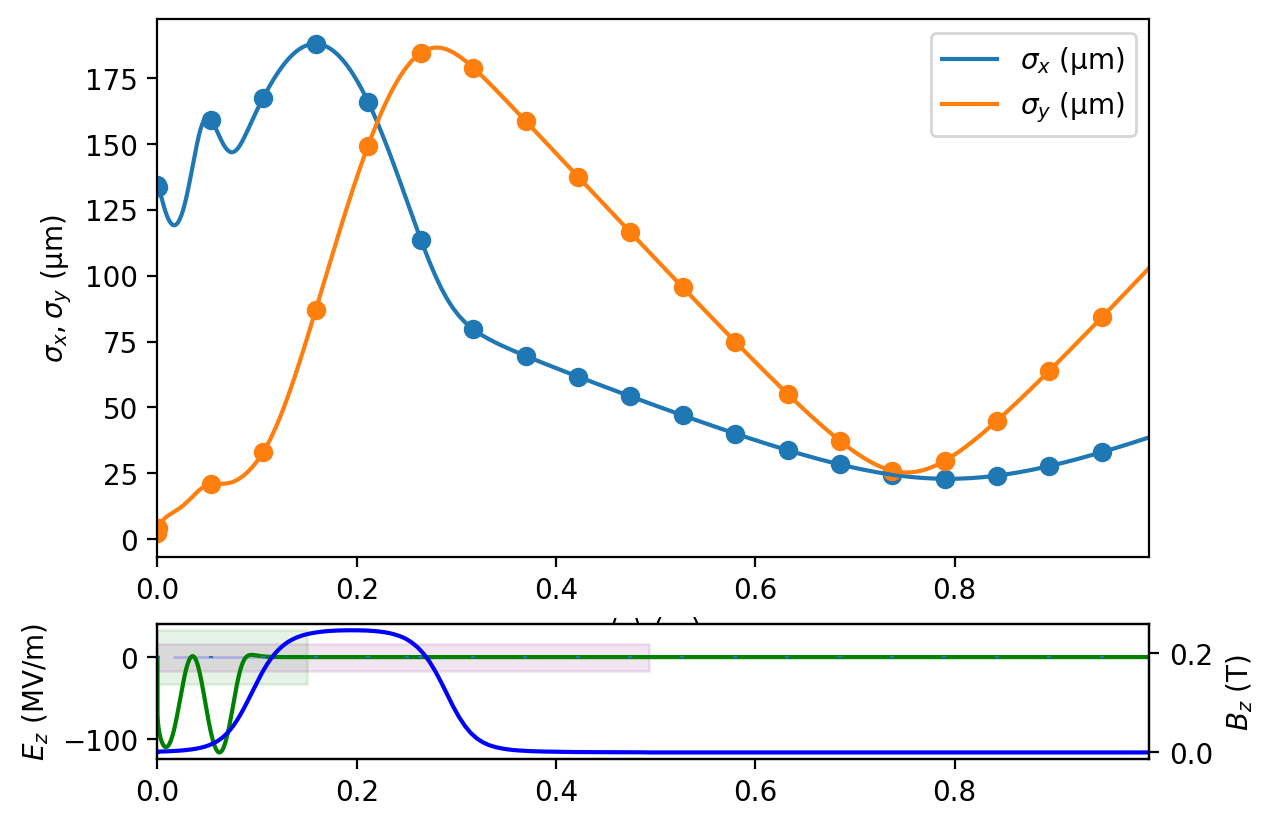

In [2]:
def run_impact(drift_to_z=False):
    ifile = 'templates/lcls_injector/ImpactT.in'
    I = Impact(ifile, verbose=False)
    I.header['Np'] = 1000
    # Turn Space Charge off.
    I.header['Bcurr'] = 0 
    if drift_to_z:
        I.header['Flagdiag'] = 2 
    else: 
        I.header['Flagdiag'] = 1 
    I.stop = 1
    I.numprocs = 4
    # Make a list of s
    for s in np.linspace(.001, 1, 20):
       ele = new_write_beam(s=s, ref_eles=I.lattice) # ref_eles will ensure that there are no naming conflicts
       I.add_ele(ele)
    I.run()
    return I


# Make two sets of data
It = run_impact( drift_to_z=False)
Iz = run_impact( drift_to_z=True)

It.plot()

# Compare drift to z off/on:

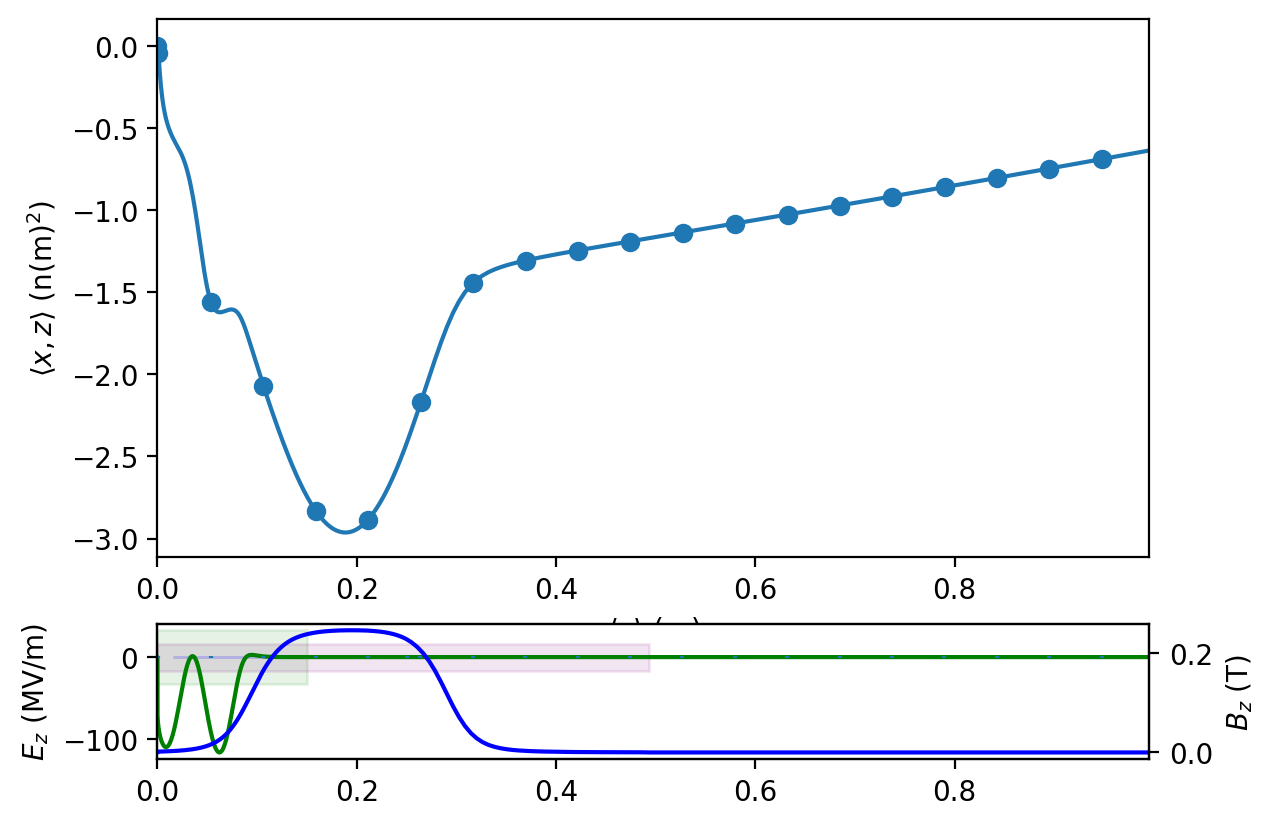

In [3]:
for key in ('cov_x__z', 'cov_x__pz', 'cov_y__z', 'cov_y__pz')[0:1]:
    It.plot(key)

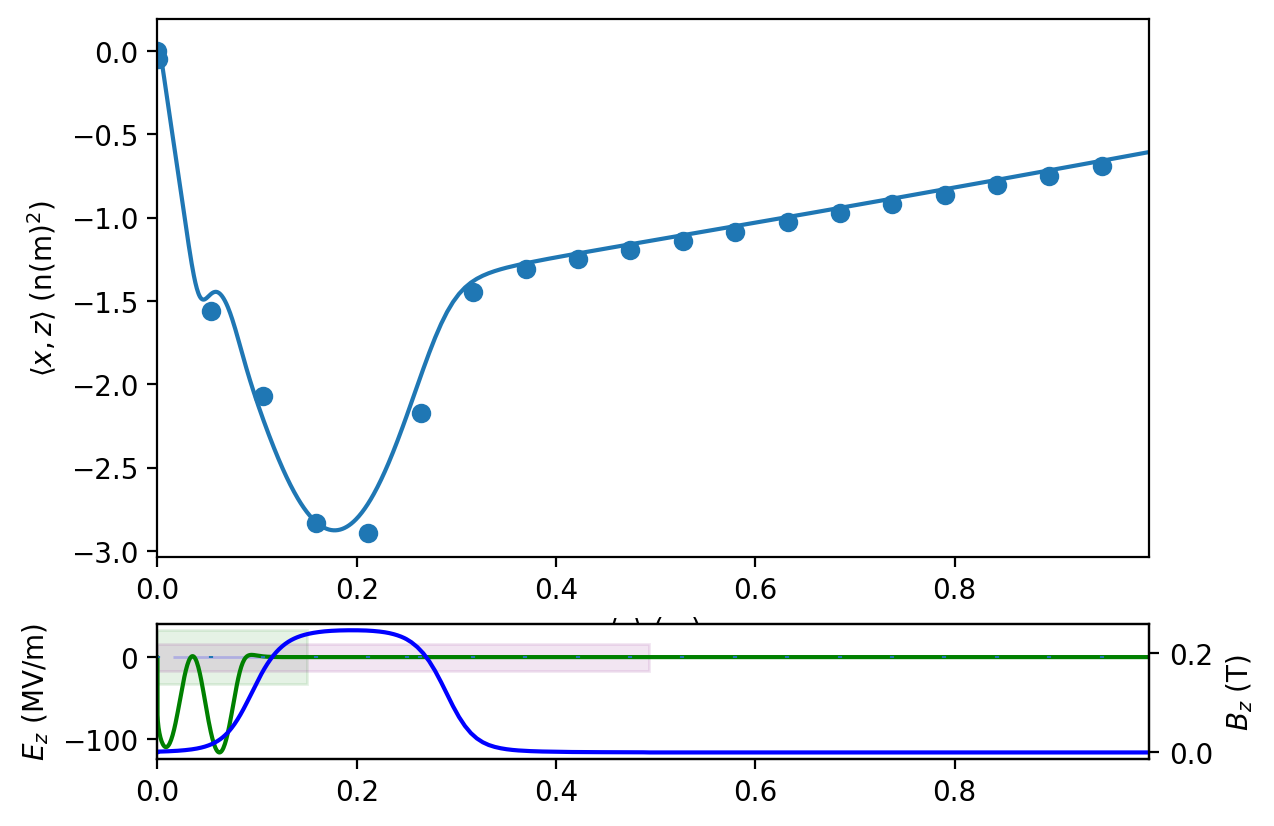

In [4]:
for key in ('cov_x__z', 'cov_x__pz', 'cov_y__z', 'cov_y__pz')[0:1]:
    Iz.plot(key)

# fort.32 covariance matrix data

Load and label the data

In [5]:
root = Path(It.path)

In [6]:
fdat = np.loadtxt(root/'fort.32')[-1, :]
labels = ['z',
 'z0avg*xl',
 'xl',
 'sqsum1',
 'xpx',
 'xy',
 'xpy',
 'xz',
 'xpz',
 'sqsum2',
 'ypx',
 'pxpy',
 'zpx',
 'pxpz',
 'sqsum3',
 'ypy',
 'yz',
 'ypz',
 'sqsum4',
 'zpy',
 'pypz',
 'sqsum5',
 'zpz',
 'sqsum6']
fstat = {}
for label, dat in zip(labels, fdat):
    fstat[label] = dat

xl = fstat['xl']
fstat

{'z': np.float64(3.3522667e-09),
 'z0avg*xl': np.float64(0.99556375),
 'xl': np.float64(0.00014989623),
 'sqsum1': np.float64(1.4974151e-09),
 'xpx': np.float64(5.6178899e-08),
 'xy': np.float64(3.6500158e-09),
 'xpy': np.float64(1.7008492e-07),
 'xz': np.float64(-6.3667964e-10),
 'xpz': np.float64(5.9237308e-09),
 'sqsum2': np.float64(3.2497525e-06),
 'ypx': np.float64(1.7756252e-07),
 'pxpy': np.float64(8.3563017e-06),
 'zpx': np.float64(1.2679441e-08),
 'pxpz': np.float64(2.768486e-07),
 'sqsum3': np.float64(1.062041e-08),
 'ypy': np.float64(4.7898066e-07),
 'yz': np.float64(-1.7687145e-09),
 'ypz': np.float64(1.6545103e-08),
 'sqsum4': np.float64(2.2991086e-05),
 'zpy': np.float64(3.1824537e-08),
 'pypz': np.float64(7.8974858e-07),
 'sqsum5': np.float64(8.3978726e-08),
 'zpz': np.float64(3.5686841e-08),
 'sqsum6': np.float64(3.6262377e-06)}

In [7]:
F = fstat
fcov = np.array([
     [F['sqsum1'], F['xpx'], F['xy'], F['xpy'], F['xz'], F['xpz']],
      [0,                   F['sqsum2'], F['ypx'], F['pxpy'], F['zpx'], F['pxpz']],
      [0, 0, F['sqsum3'], F['ypy'], F['yz'], F['ypz']],
      [0, 0, 0, F['sqsum4'], F['zpy'], F['pypz']],
      [0, 0, 0,0, F['sqsum5'], F['zpz']],
      [0, 0, 0, 0, 0,  F['sqsum6']],
    ])
# Make the matrix symmetric by copying upper triangle to lower triangle
for i in range(6):
    for j in range(6):
        fcov[j, i] = fcov[i, j]


fcov*1e9

array([[1.50e+00, 5.62e+01, 3.65e+00, 1.70e+02, -6.37e-01, 5.92e+00],
       [5.62e+01, 3.25e+03, 1.78e+02, 8.36e+03, 1.27e+01, 2.77e+02],
       [3.65e+00, 1.78e+02, 1.06e+01, 4.79e+02, -1.77e+00, 1.65e+01],
       [1.70e+02, 8.36e+03, 4.79e+02, 2.30e+04, 3.18e+01, 7.90e+02],
       [-6.37e-01, 1.27e+01, -1.77e+00, 3.18e+01, 8.40e+01, 3.57e+01],
       [5.92e+00, 2.77e+02, 1.65e+01, 7.90e+02, 3.57e+01, 3.63e+03]])

In [8]:
print('fort.32 (* 1e9)')
printsymmat(fcov*1e9) 

fort.32 (* 1e9)
    1.50    56.18     3.65   170.08    -0.64     5.92 
          3249.75   177.56  8356.30    12.68   276.85 
                     10.62   478.98    -1.77    16.55 
                           22991.09    31.82   789.75 
                                       83.98    35.69 
                                              3626.24 


# Final particles from fort.50

Calculate the covariance matrix from the particles. Note that these aren't exactly at the same final location as the fort.32 file. Here we are looking for similar numbers. 


In [9]:
pdat = np.loadtxt(root/'fort.50')
pdat.shape

(1000, 6)

In [10]:
# Covariance
cov = np.cov(pdat.T)
cov.shape

print('fort.50 with np.cov (* 1e9)')
printsymmat(cov*1e9) 

fort.50 with np.cov (* 1e9)
    1.54    57.47     3.79   173.44    -0.60     6.05 
          3253.01   180.93  8364.67    12.70   277.13 
                     10.99   488.23    -1.67    16.90 
                           23014.10    31.87   790.54 
                                       84.06    35.73 
                                              3629.87 


# LUME-Impact plots

Compare with Lume

In [11]:
#from impact import Impact
#%config InlineBackend.figure_format = 'retina'
#
#I = Impact('ImpactT.in', workdir = '.', use_temp_dir=False)
#I.load_output()

#I.plot('cov_x__z')

In [12]:
#I.plot('cov_x__y')

In [13]:
%%time
Pz = []
for p in It.particles.values():
    p = p.copy()
    p.drift_to_z()
    Pz.append(p)
Pt = []
for p in It.particles.values():
    p = p.copy()
    p.drift_to_t()
    Pt.append(p)
Pz;

CPU times: user 3.67 ms, sys: 541 μs, total: 4.21 ms
Wall time: 4.11 ms


In [14]:
def pzstat(key):
    return np.array([p[key] for p in Pz])
def ptstat(key):
    return np.array([p[key] for p in Pt])    

In [15]:
xkey = 'mean_z'
ykey = 'cov_x__z'

I = It

def compare_drifting(I):
    fig, ax = plt.subplots()
    ax.scatter(pzstat(xkey), ptstat(ykey),  label='particles at the same t')
    #ax.scatter(pzstat(xkey), pzstat(ykey), marker='x', label='particles at the same z')# (cov_x__t)*(-c)')
    ax.scatter(pzstat(xkey), pzstat('cov_x__t')*(-c_light), marker='x', label=r'particles at the same z: $\left<x, -ct\right>$')
    ax.plot(I.stat(xkey),    I.stat(ykey), label=f"fort.32, Flagdiag = {I.header['Flagdiag']} ", color='red')
    plt.legend()
    ax.set_title(f"Flagdiag: {I.header['Flagdiag']}")
    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)

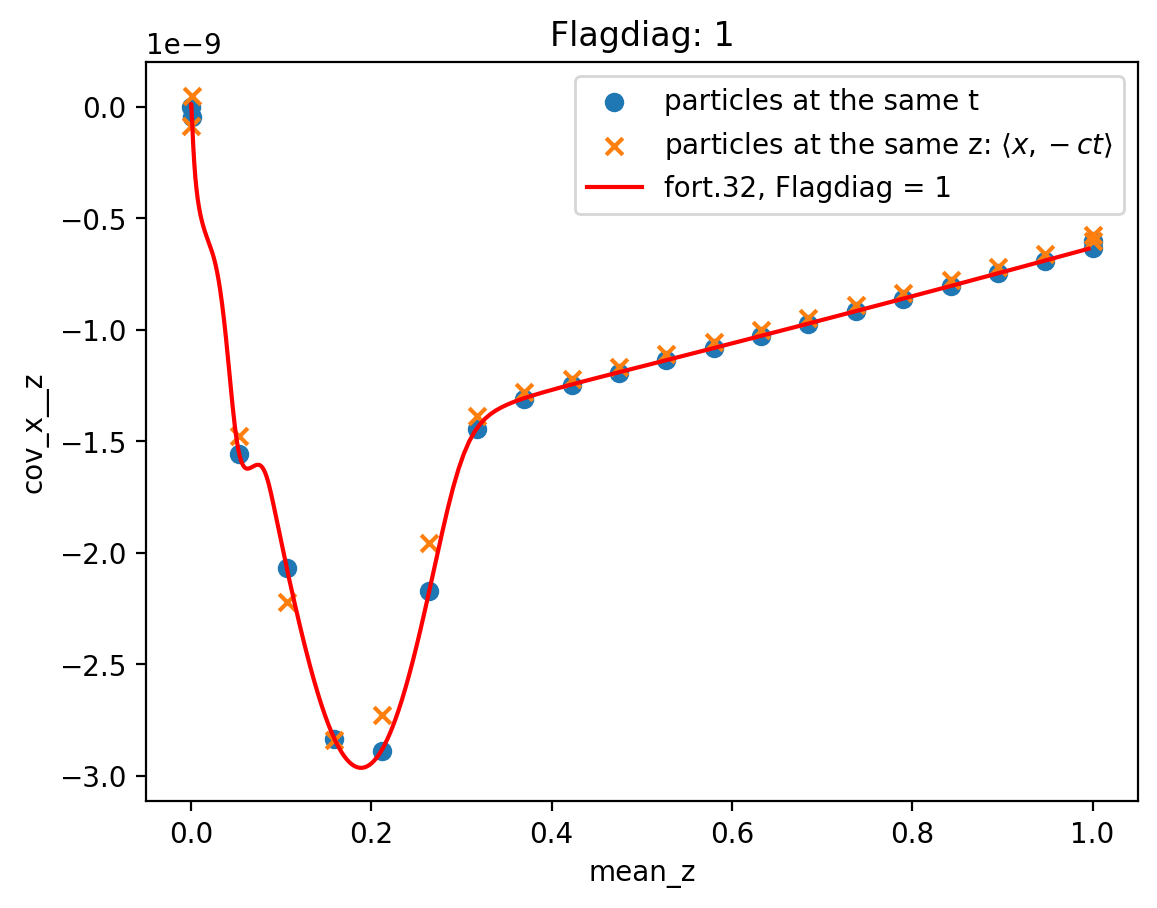

In [16]:
compare_drifting(It)

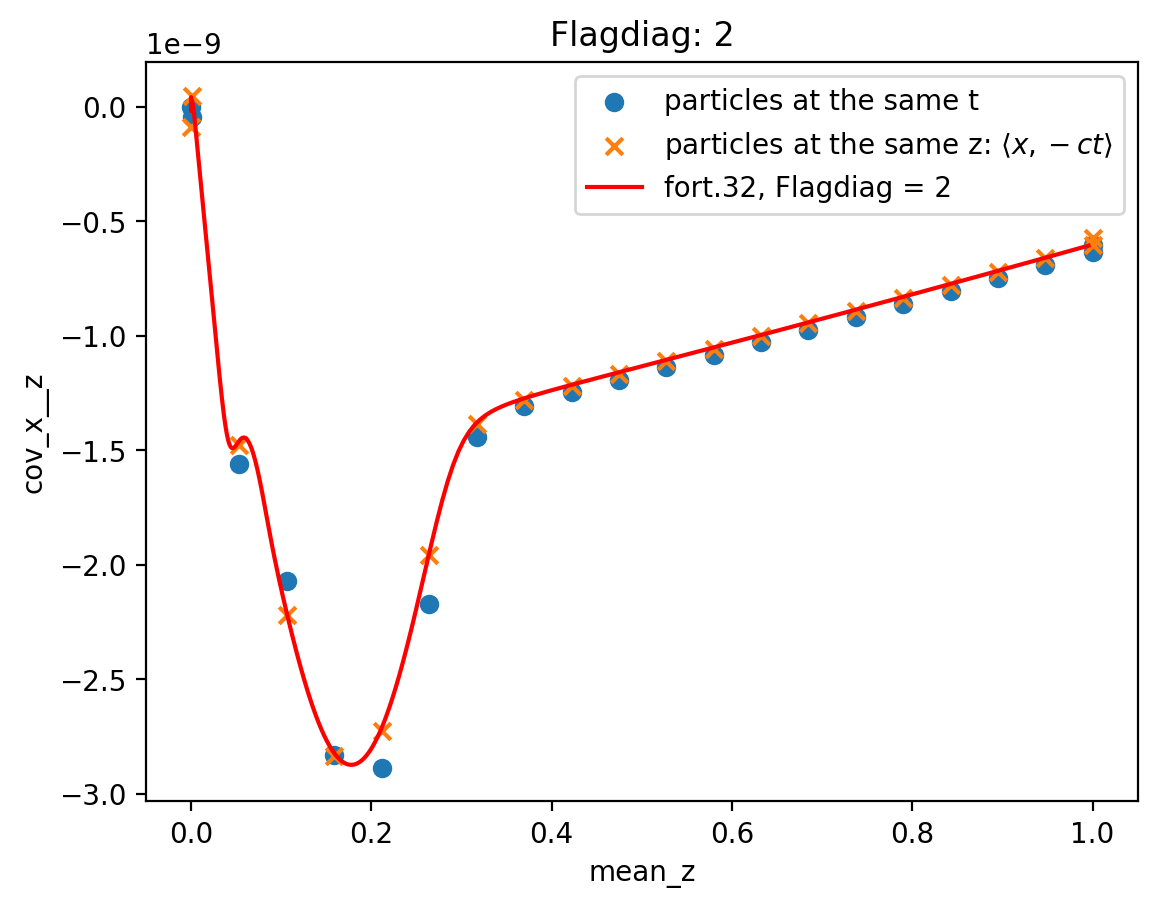

In [17]:
compare_drifting(Iz)

# Plot all 

In [18]:
plt.rcParams['figure.max_open_warning'] = 50

def plot_all_cov(I):
    stats = I.output['stats']
    for key in stats:
        if key.startswith('cov_'):
            I.plot(key)
            
          

## Flagdiag = 1 (same time)

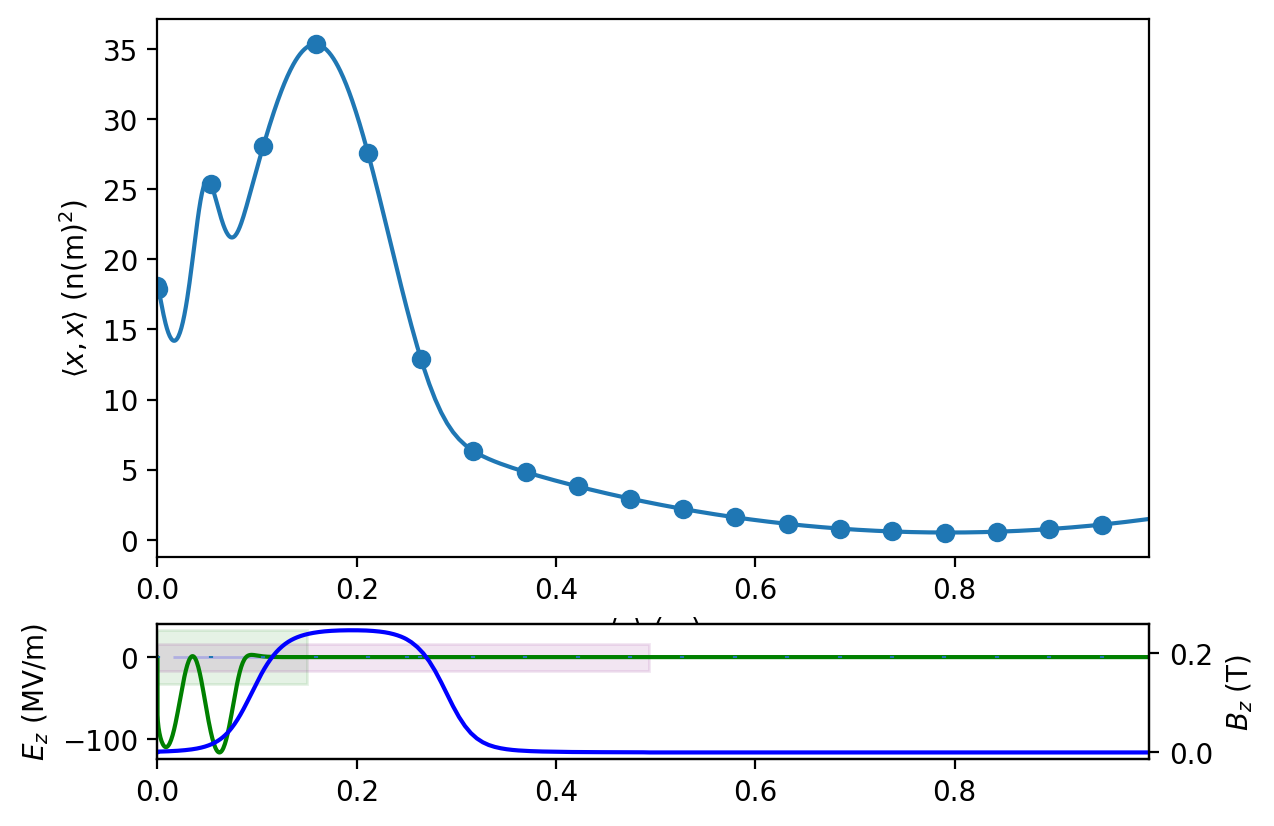

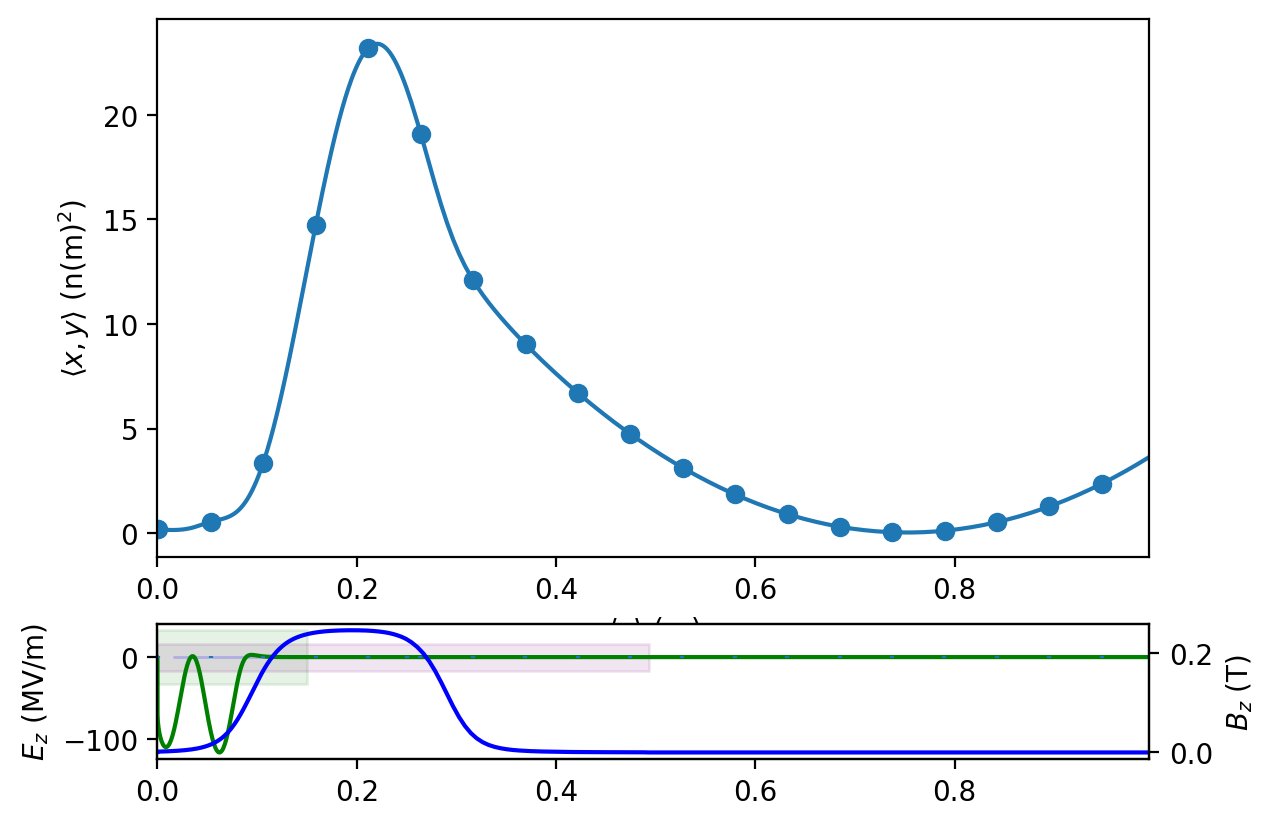

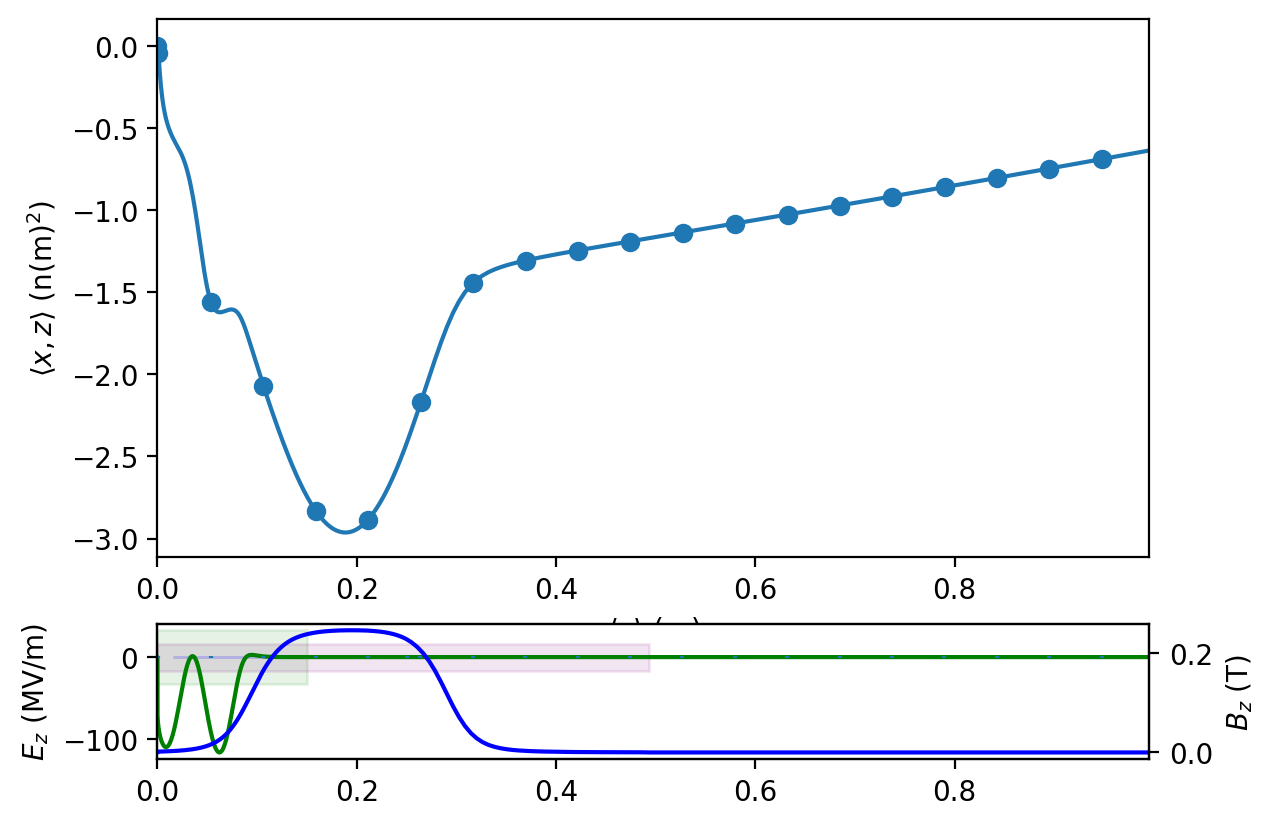

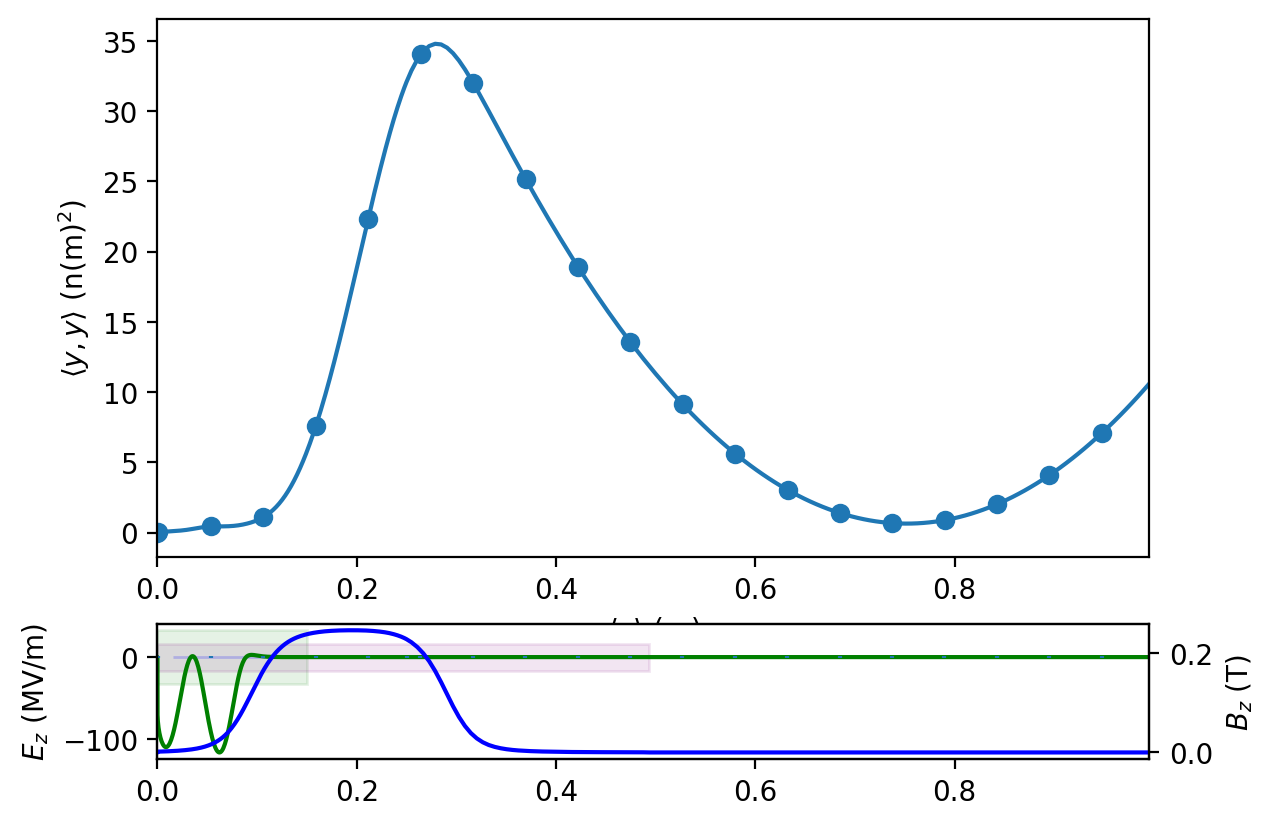

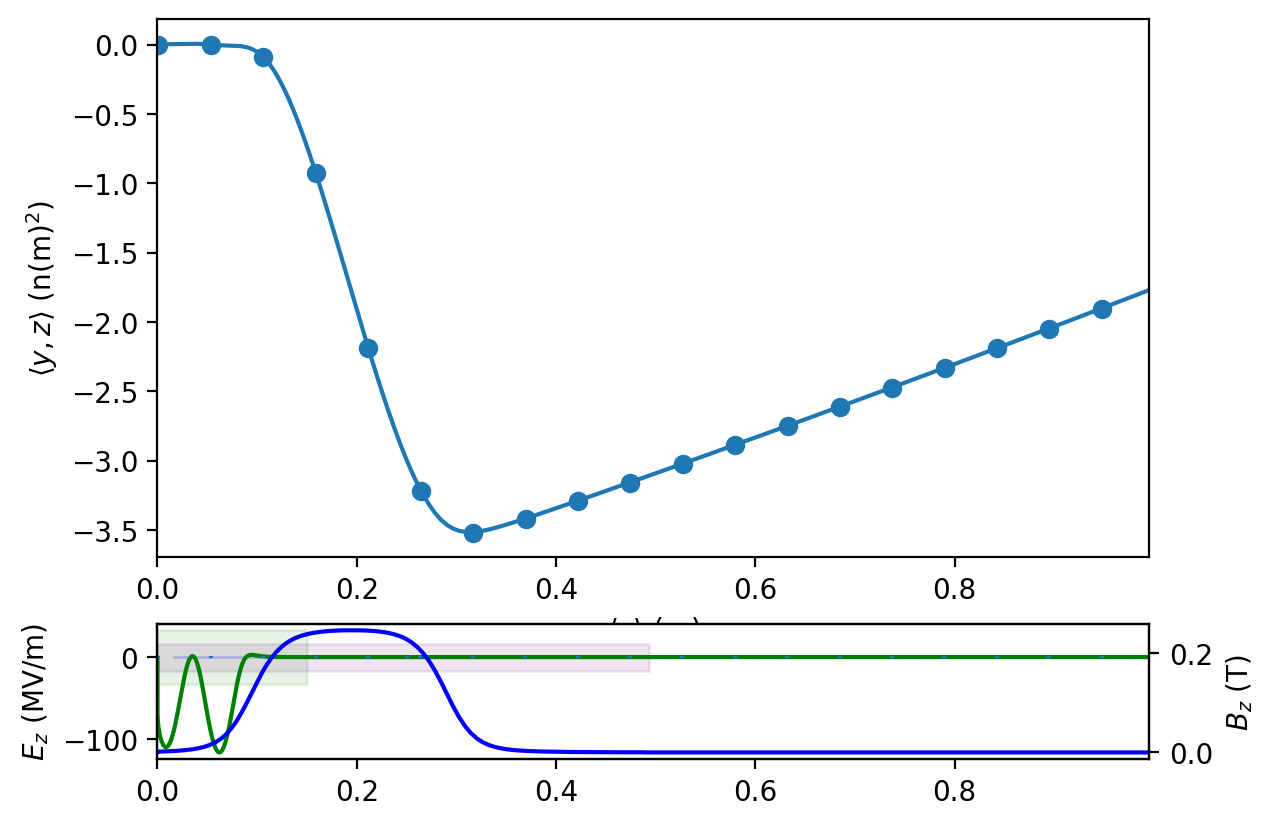

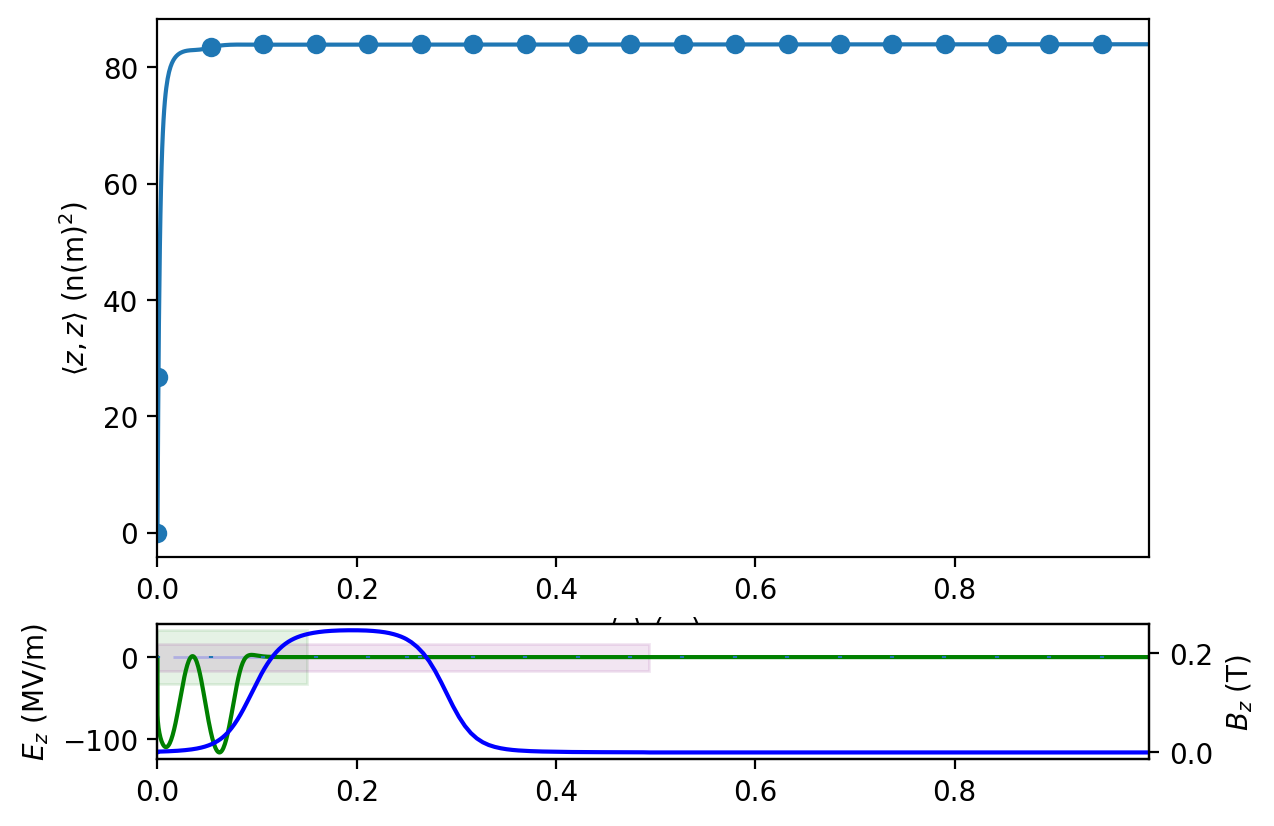

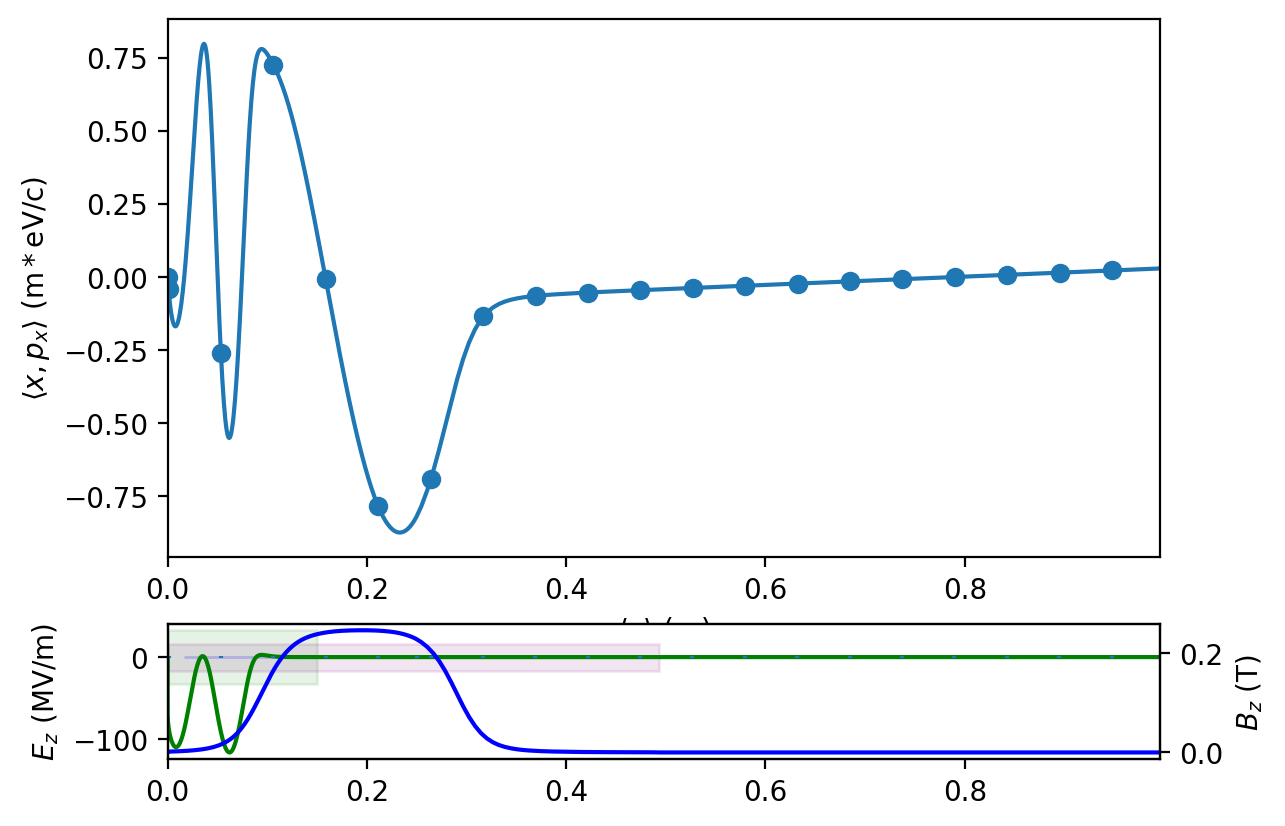

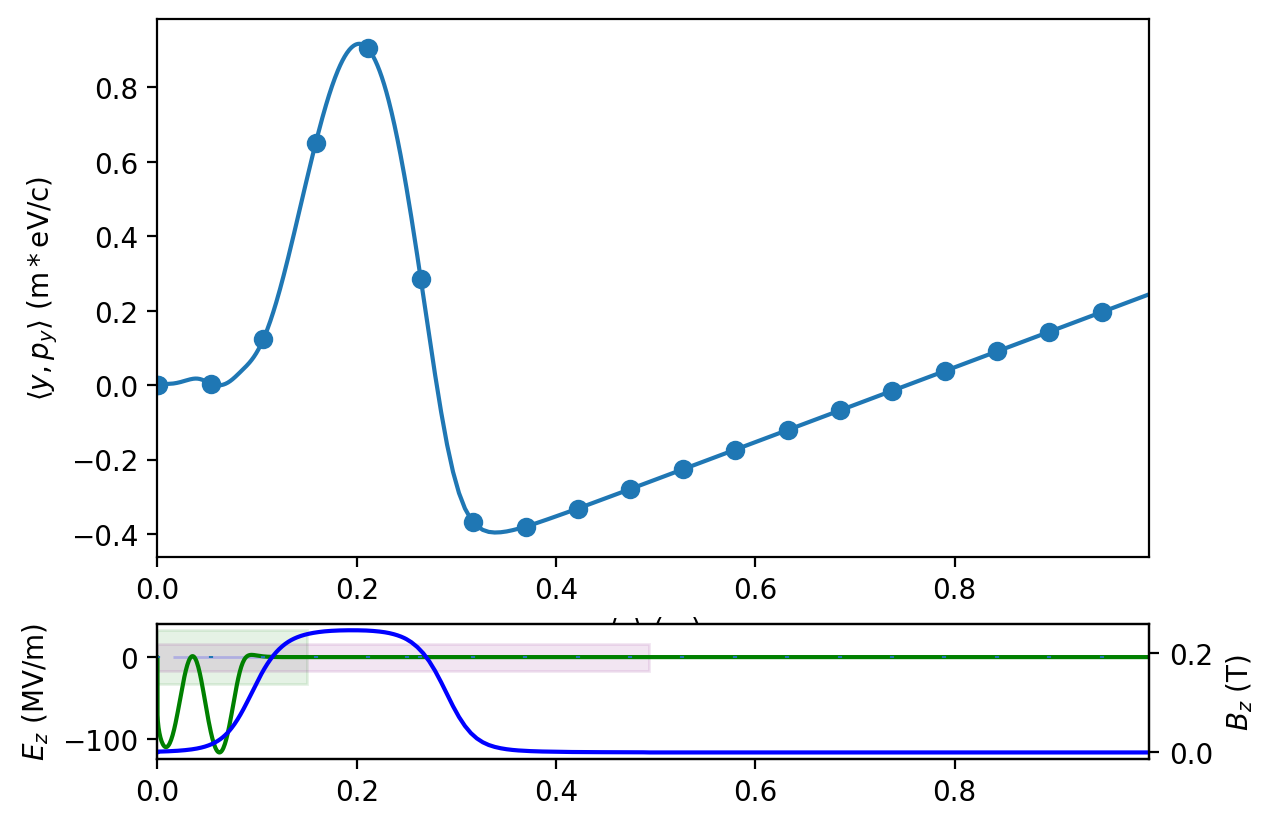

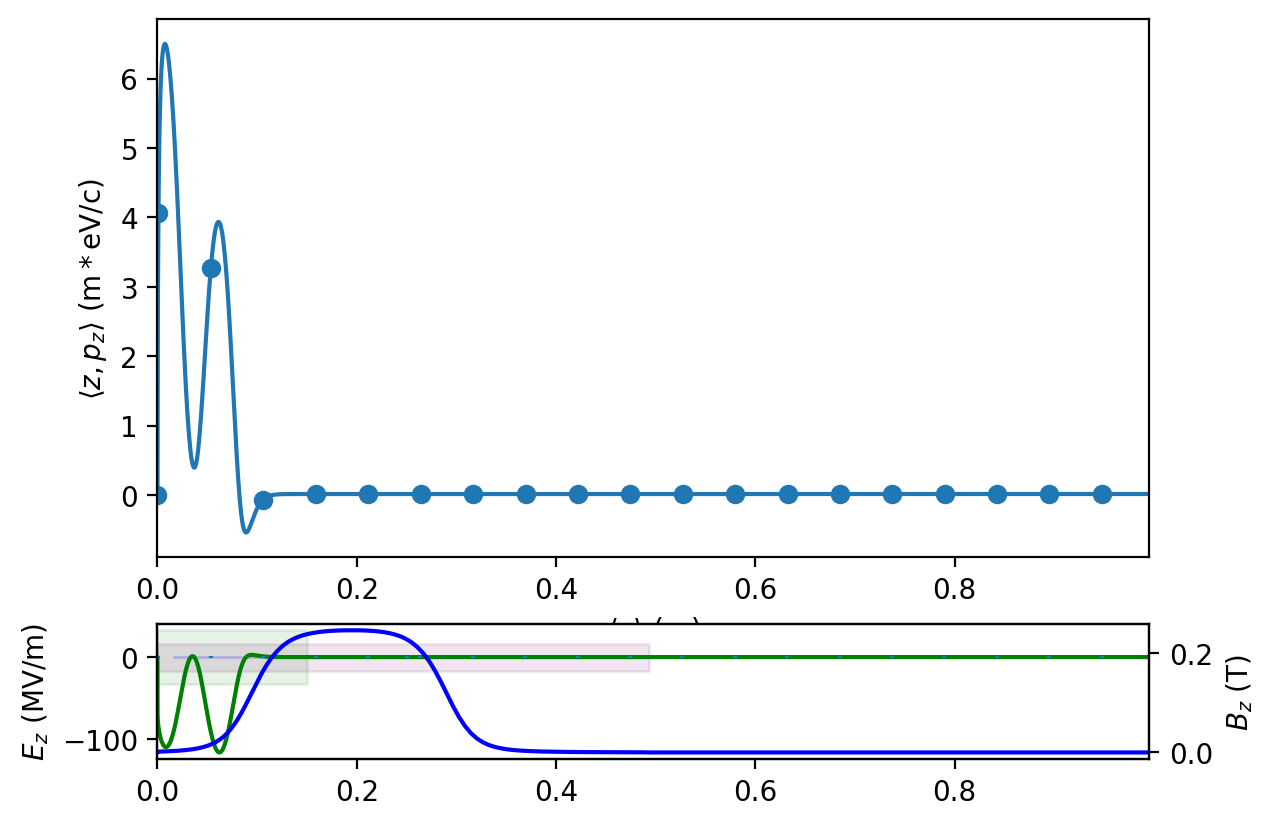

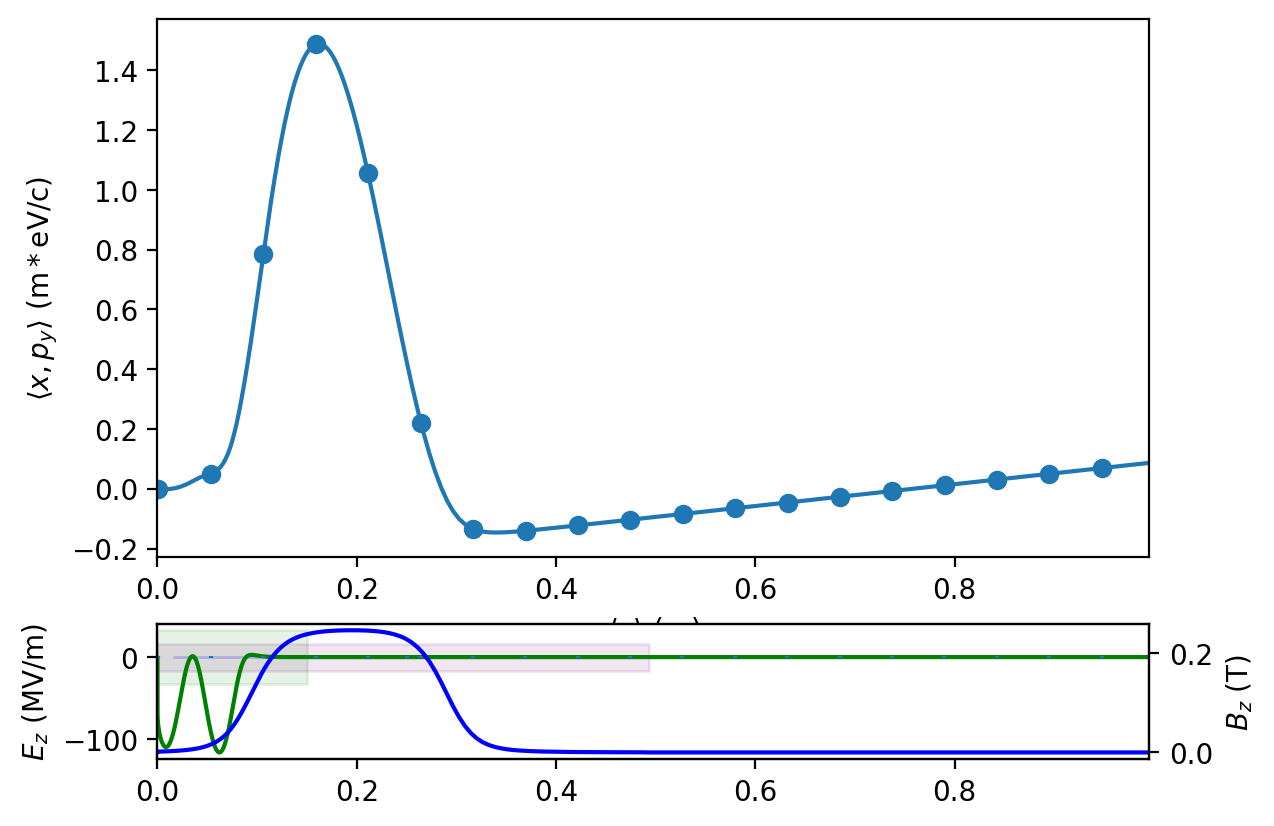

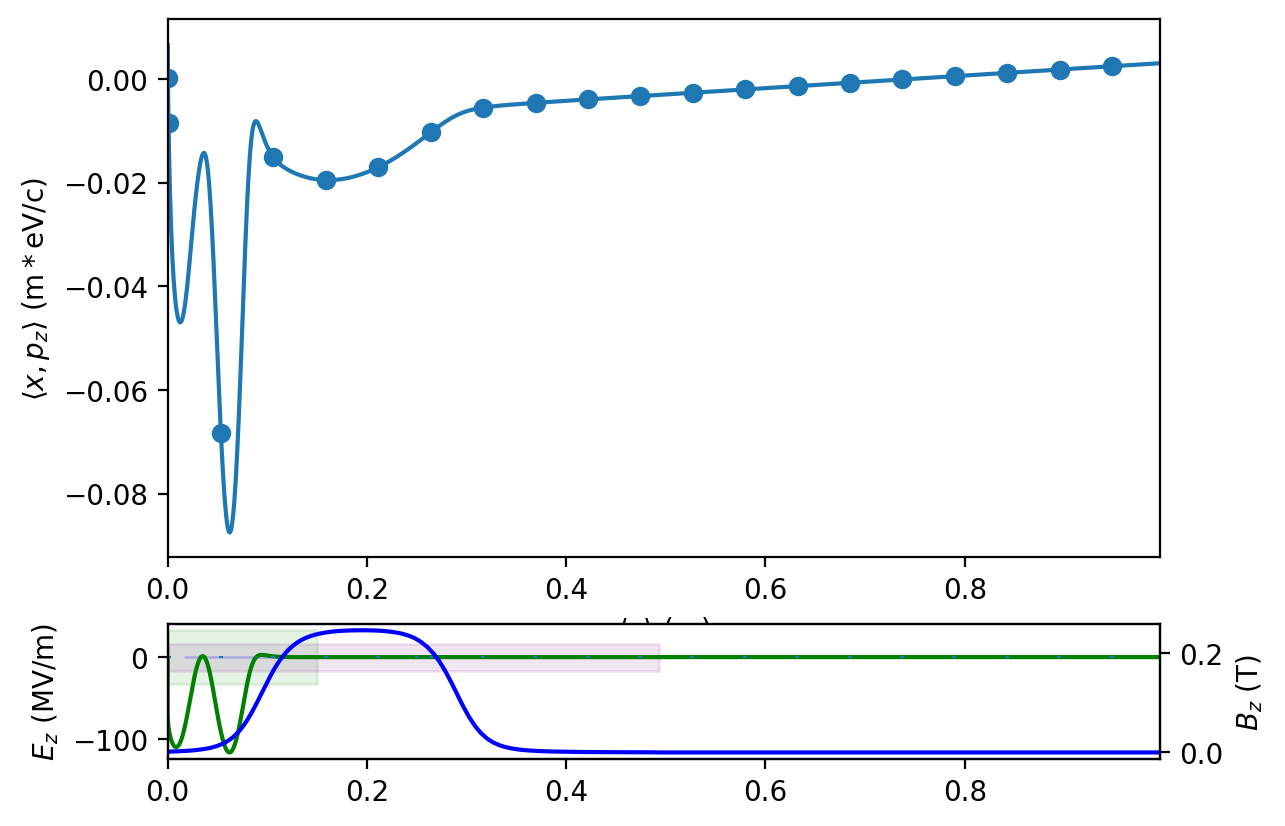

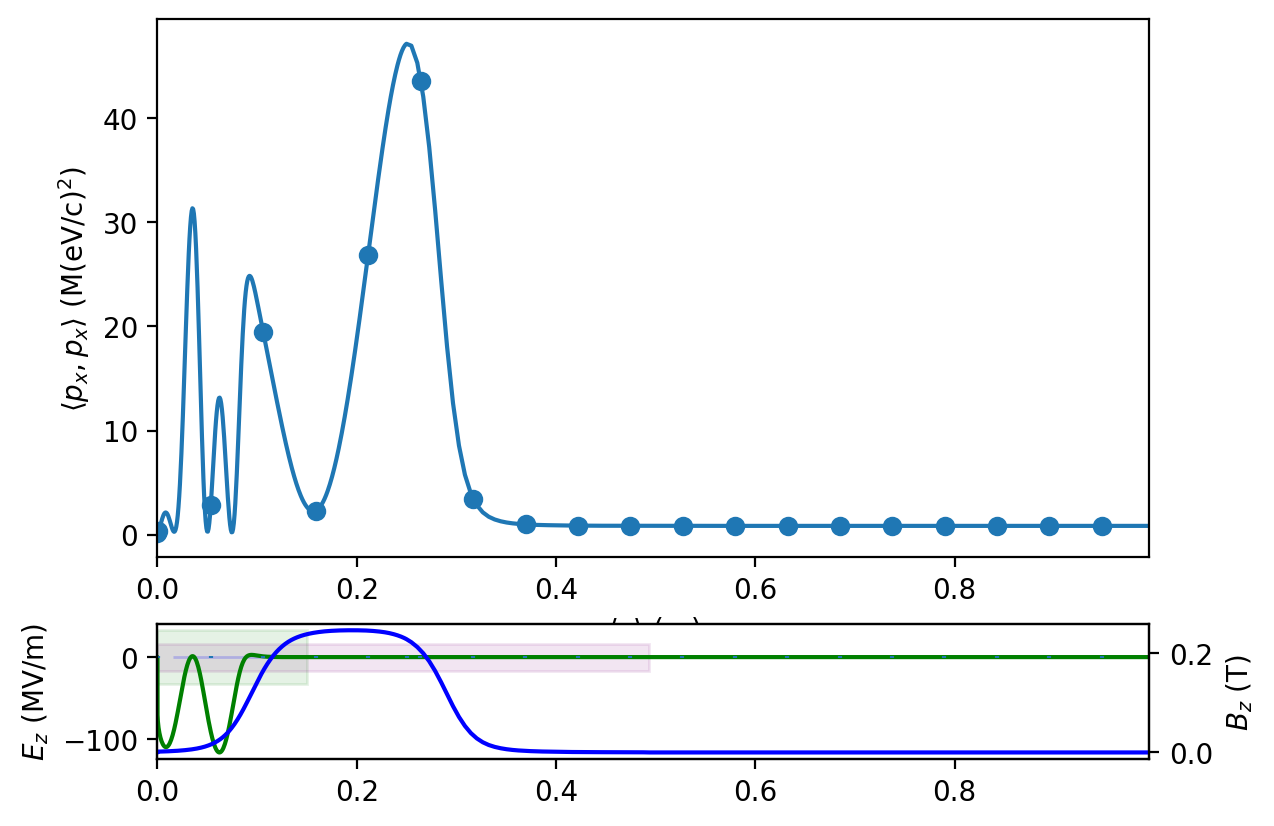

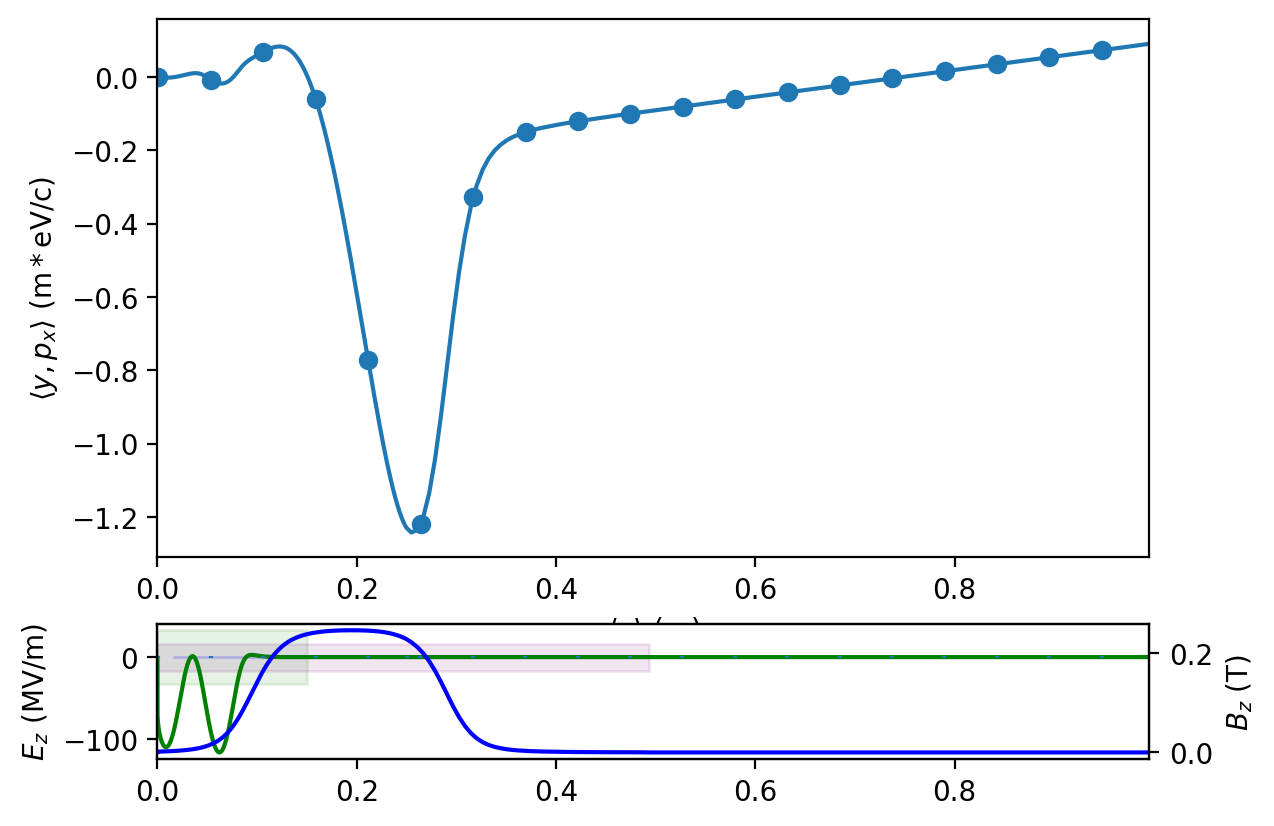

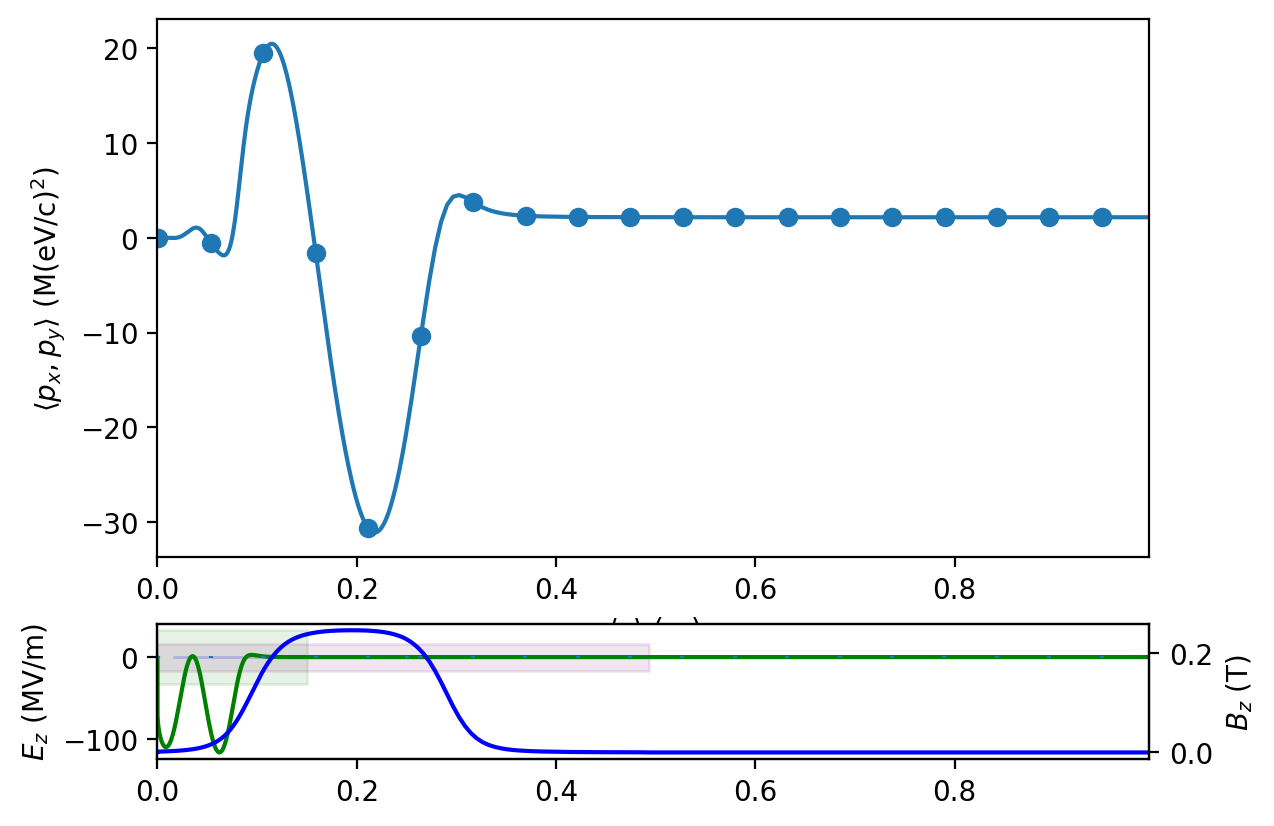

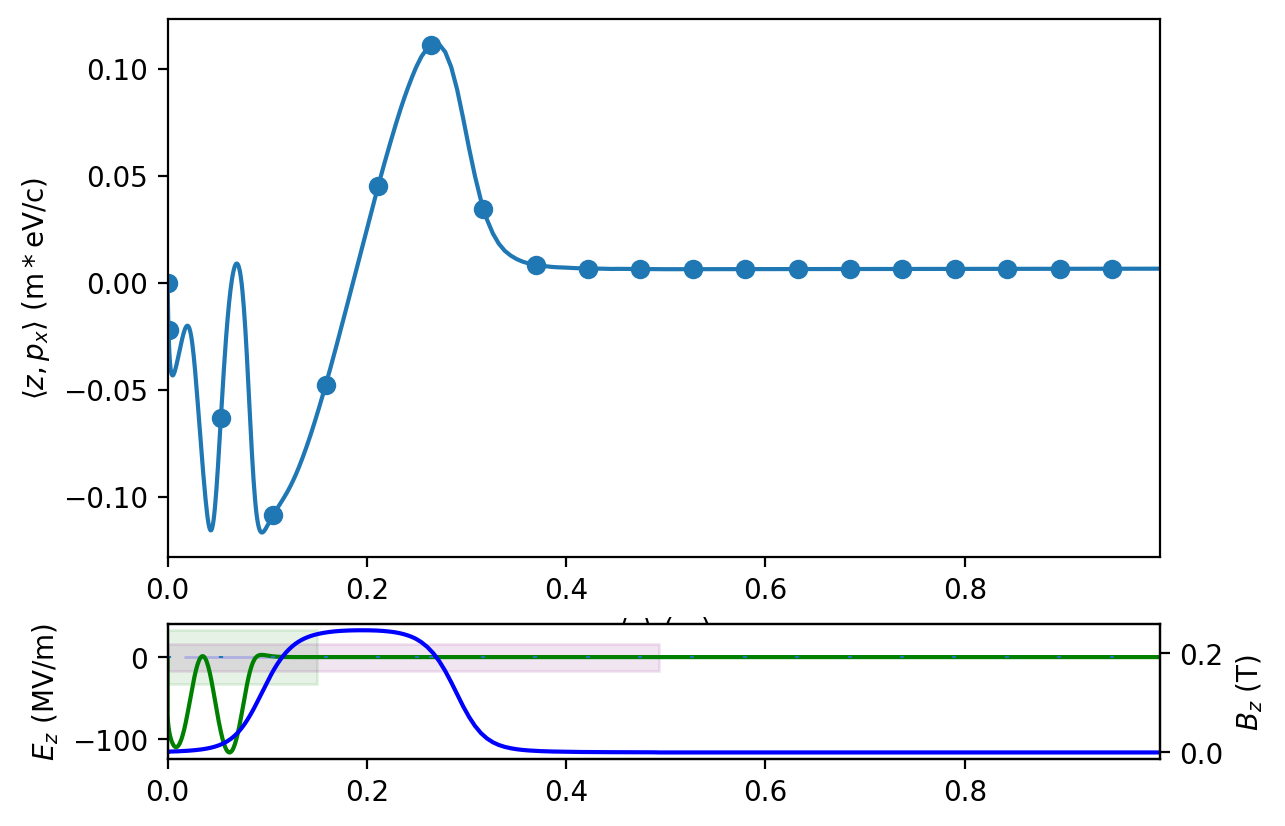

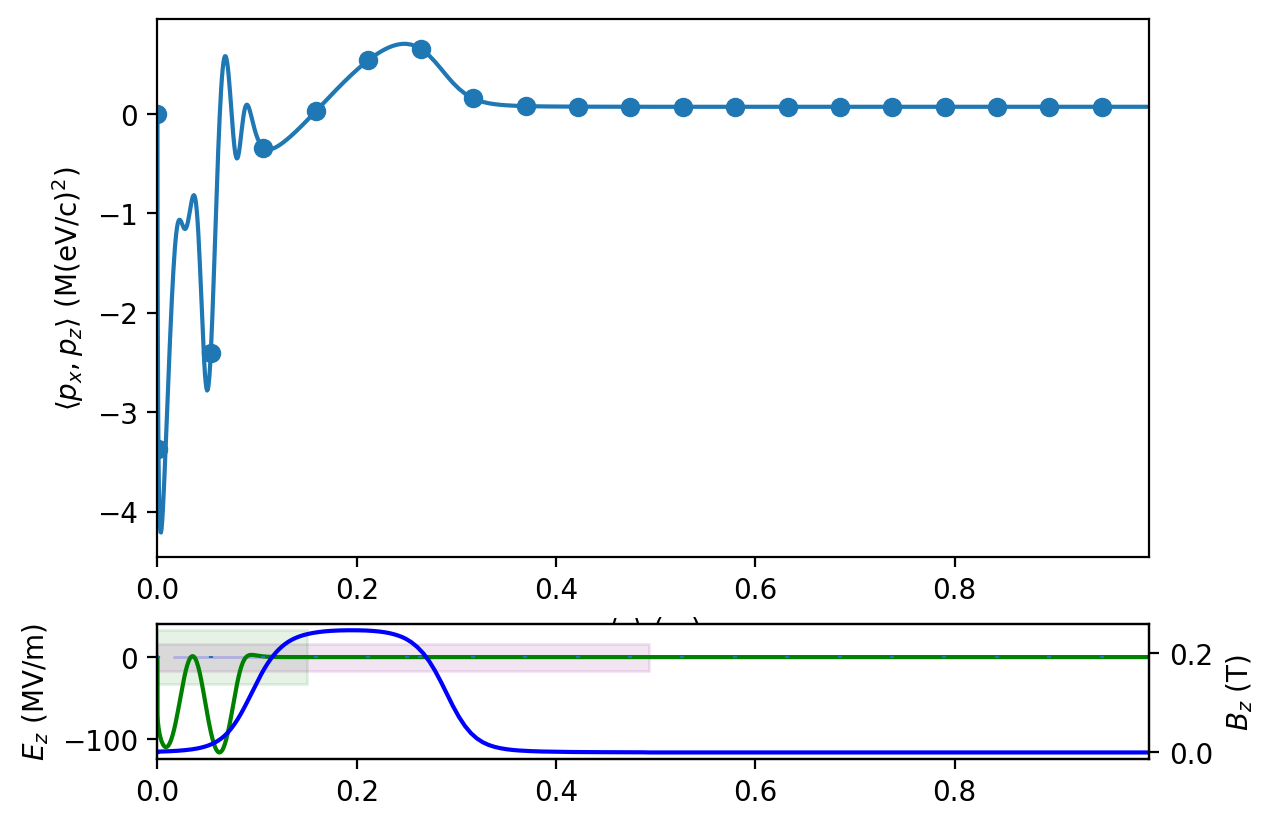

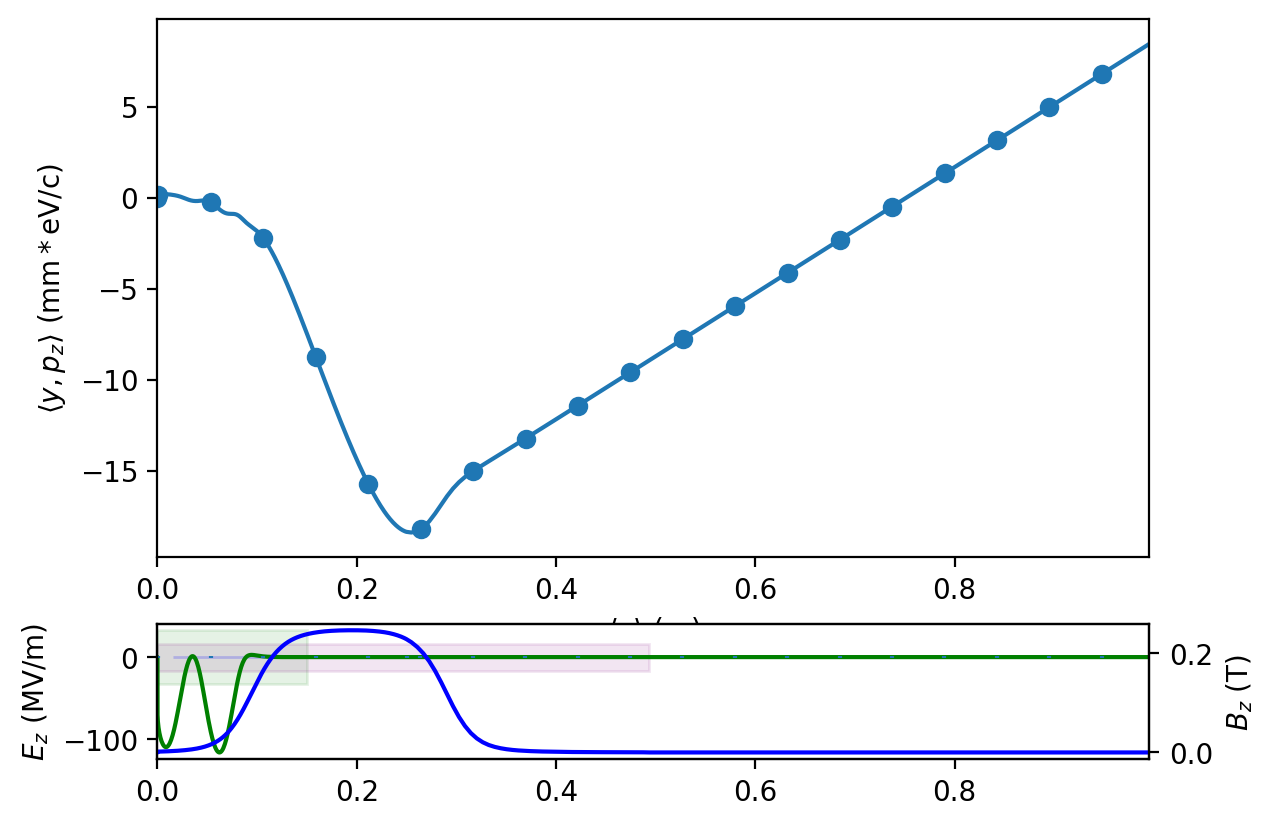

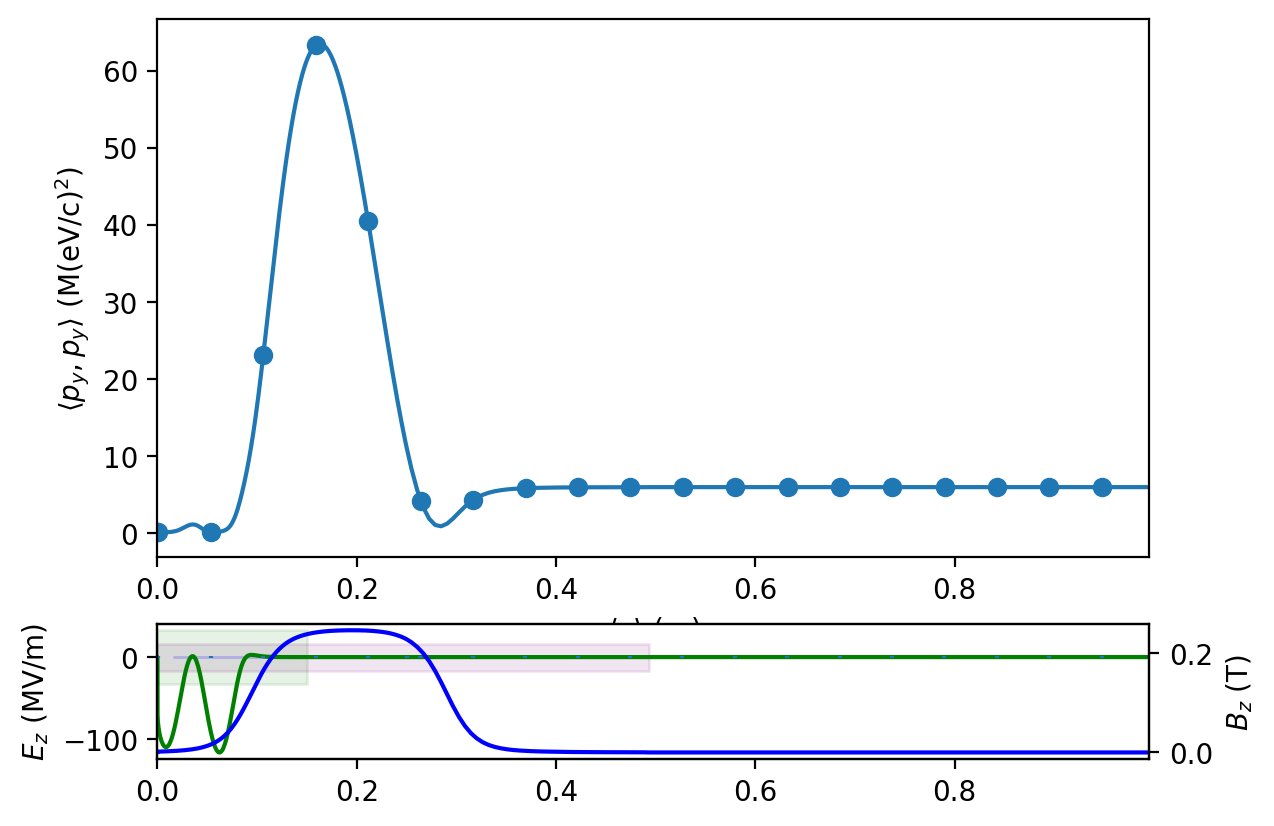

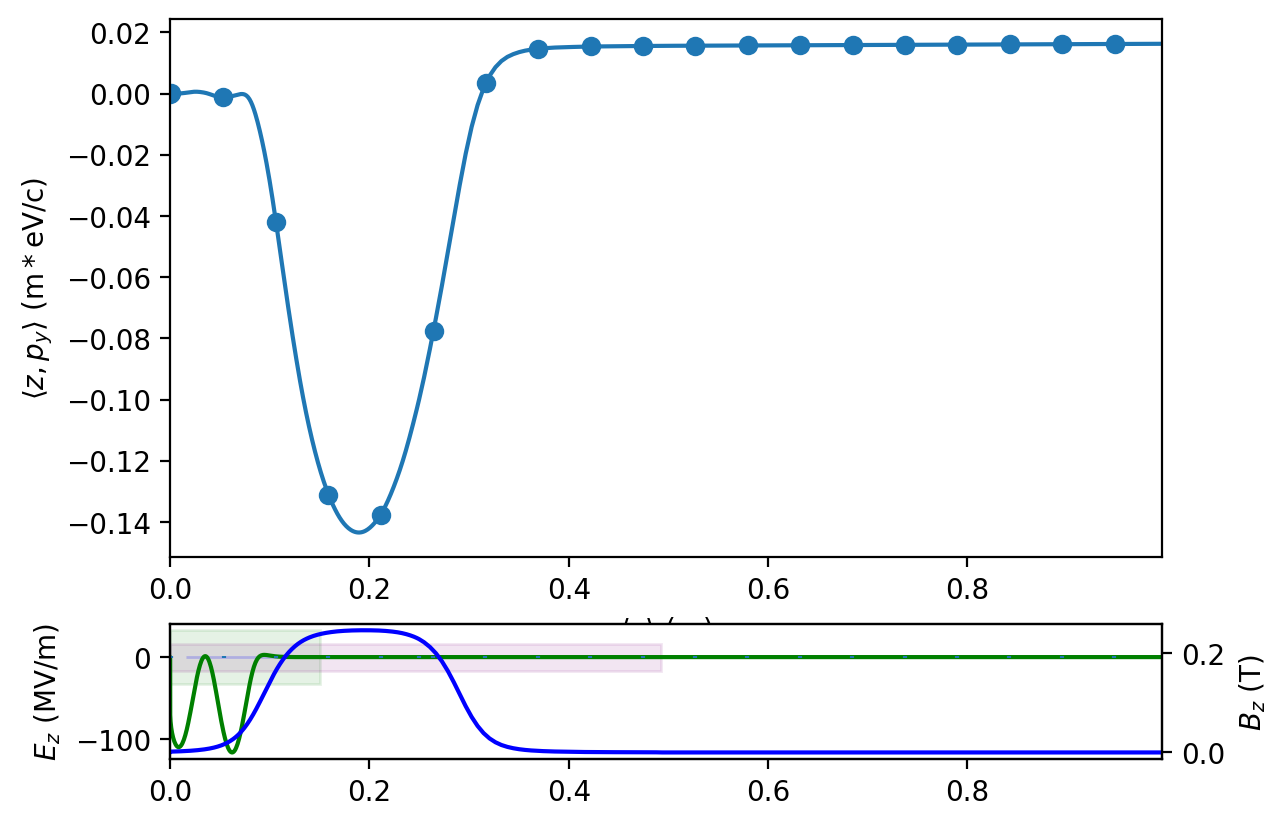

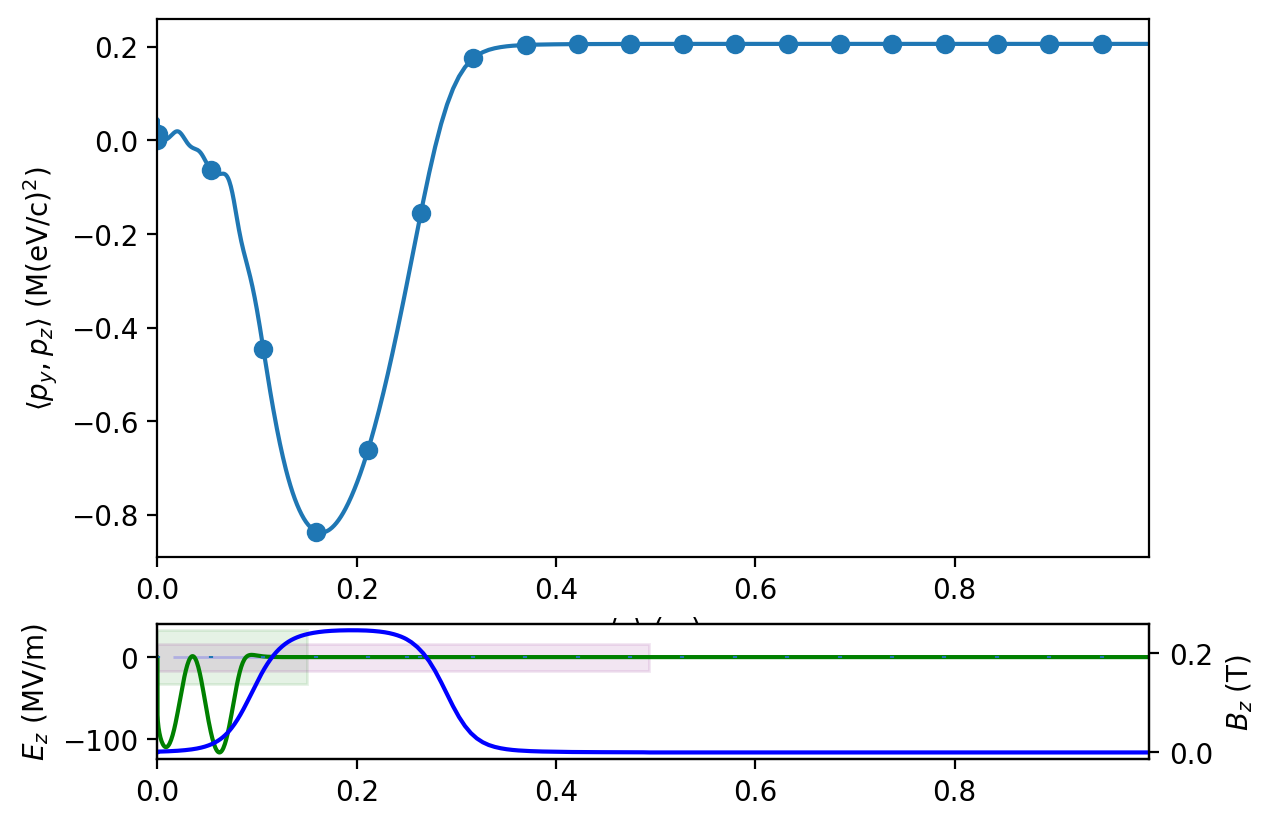

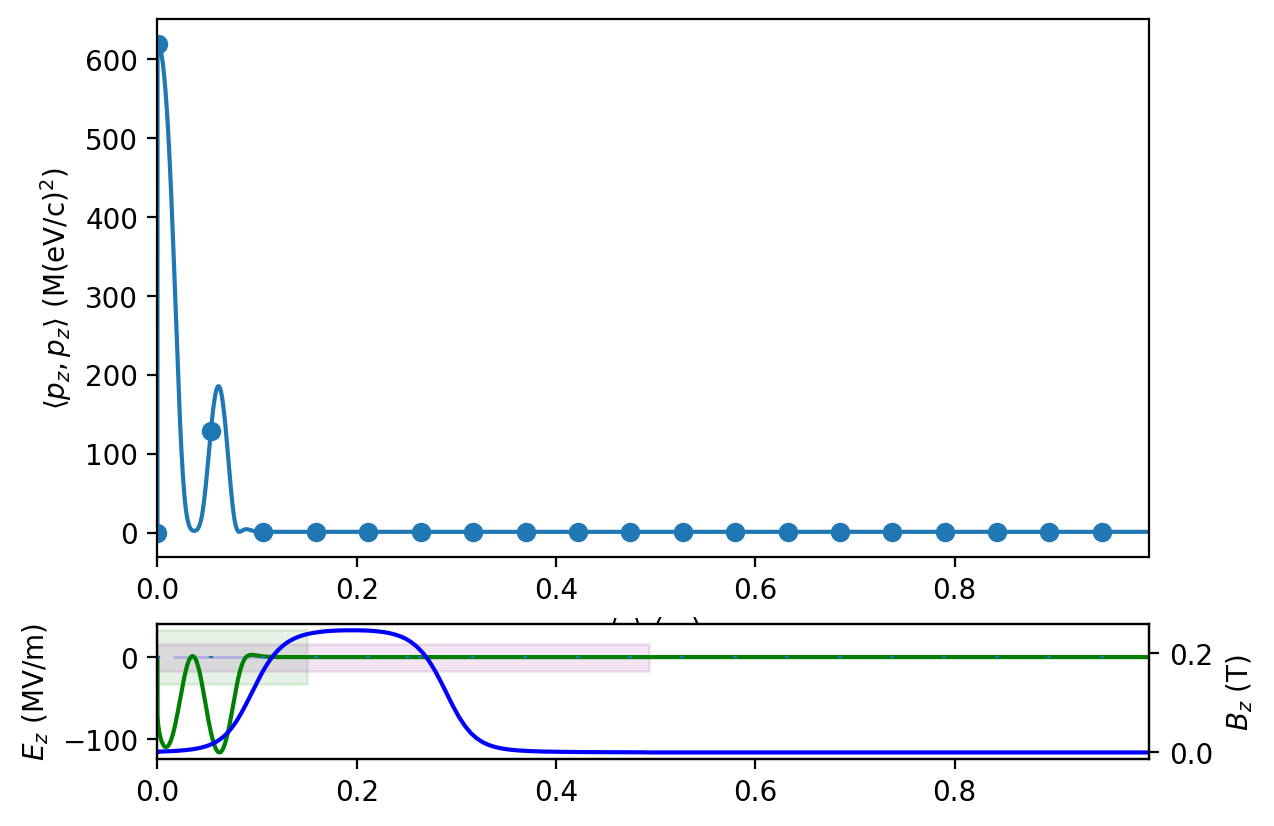

In [19]:
plot_all_cov(It)  

## Flagdiag = 2 (drift to same z)

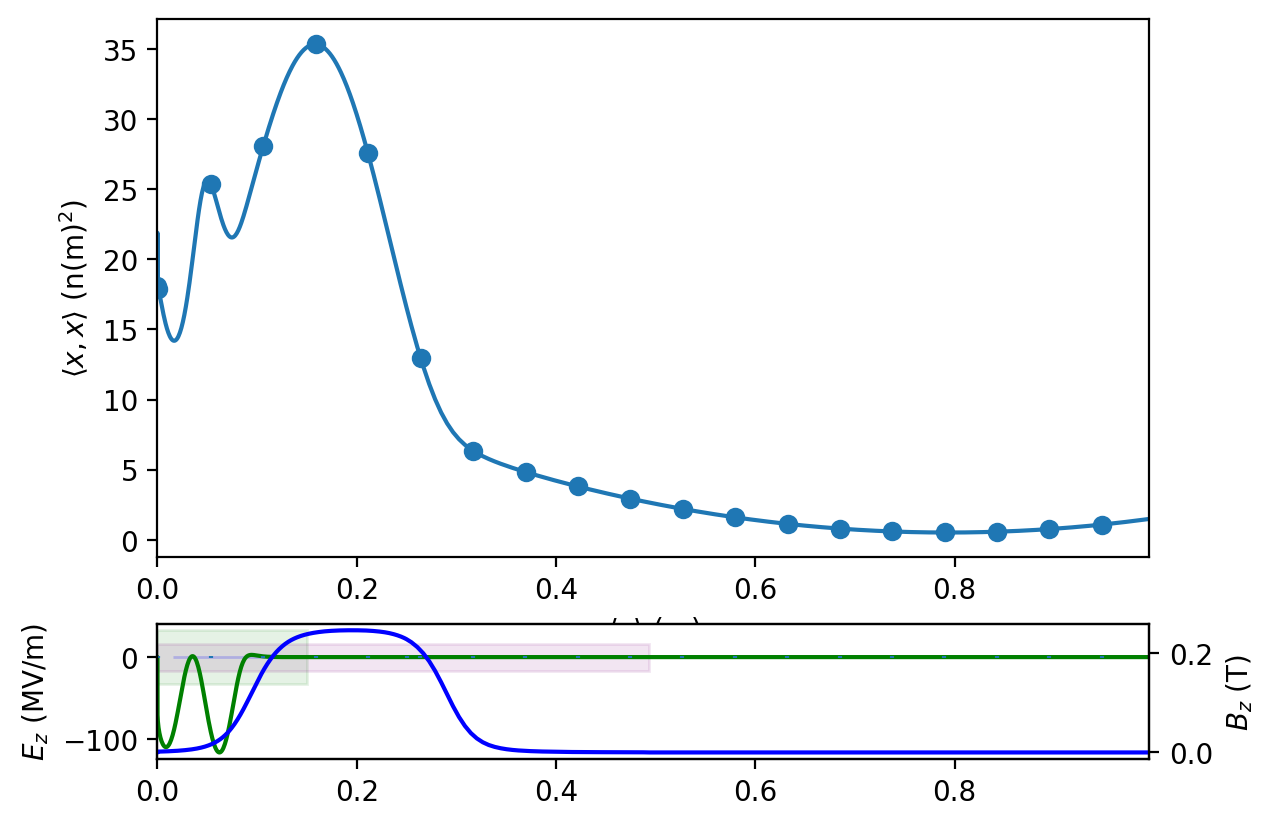

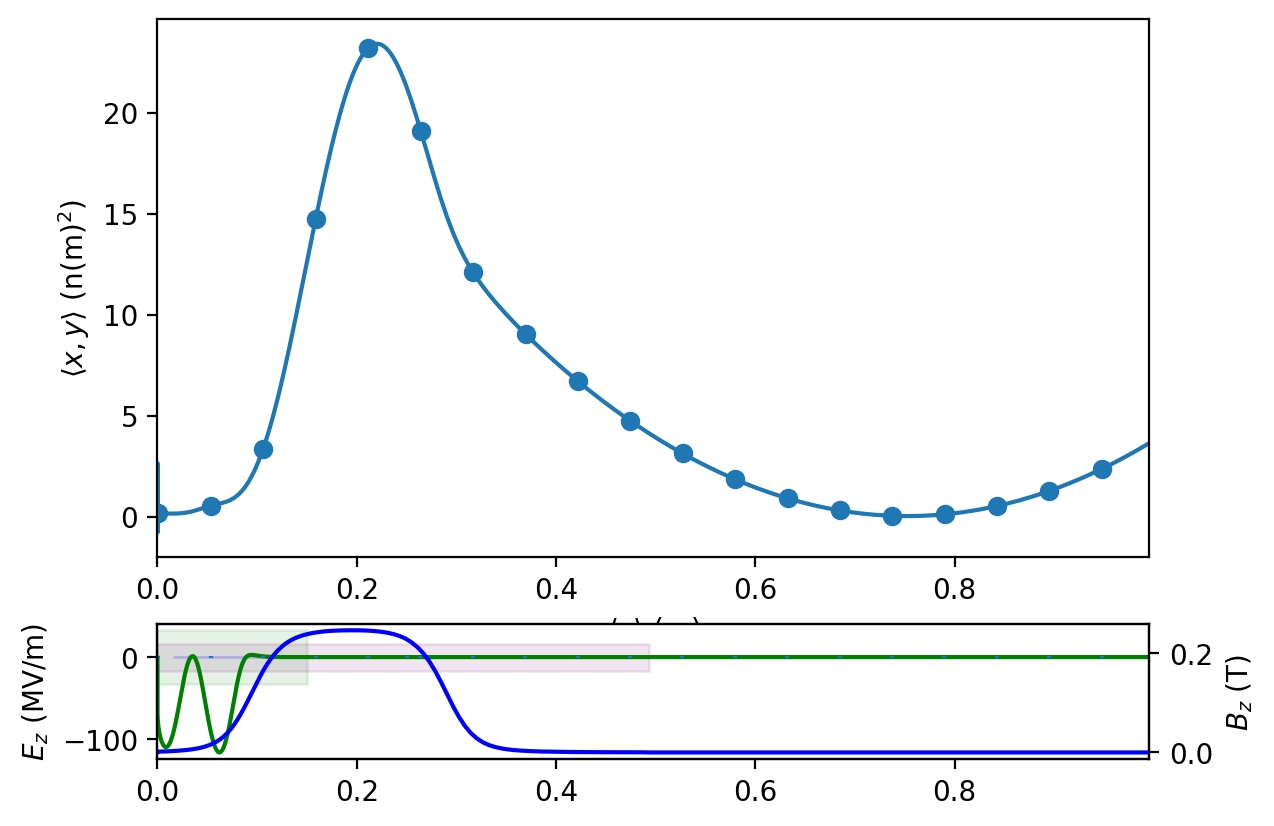

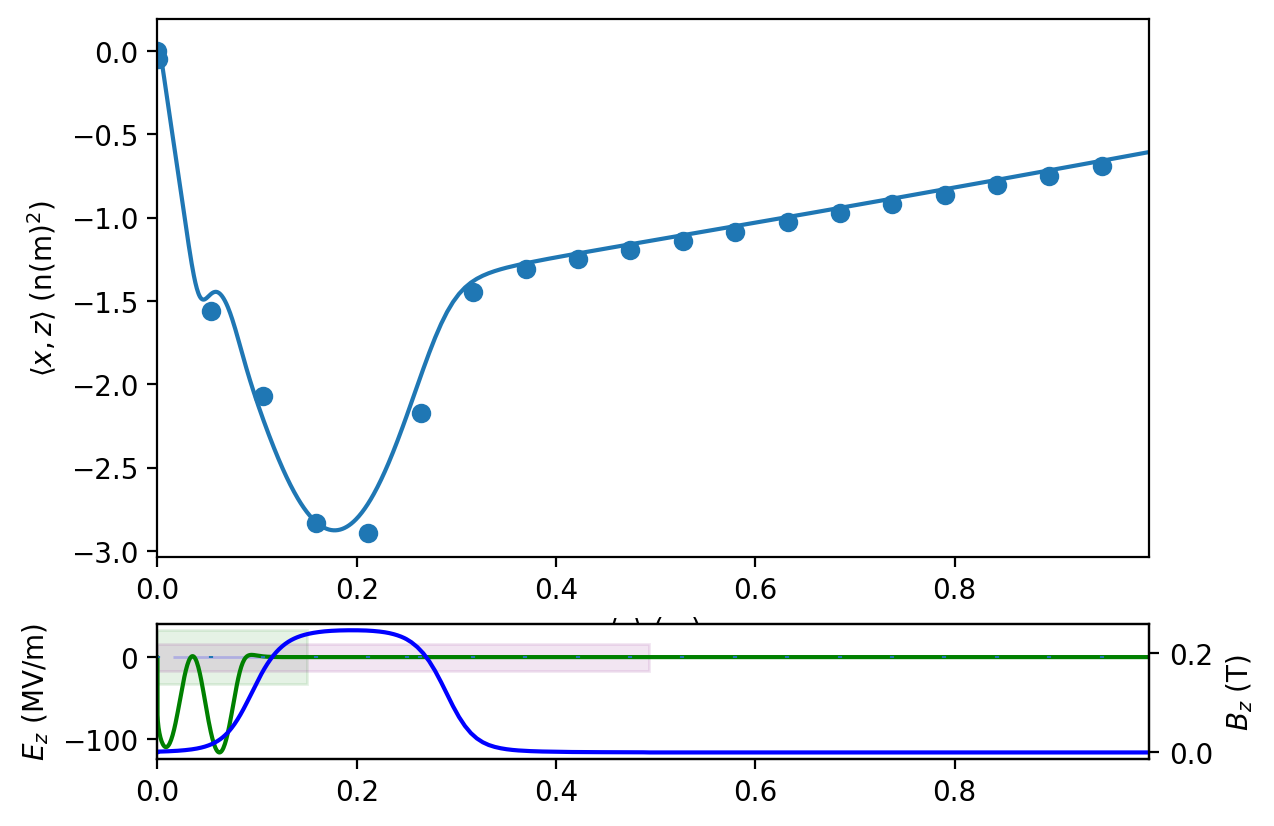

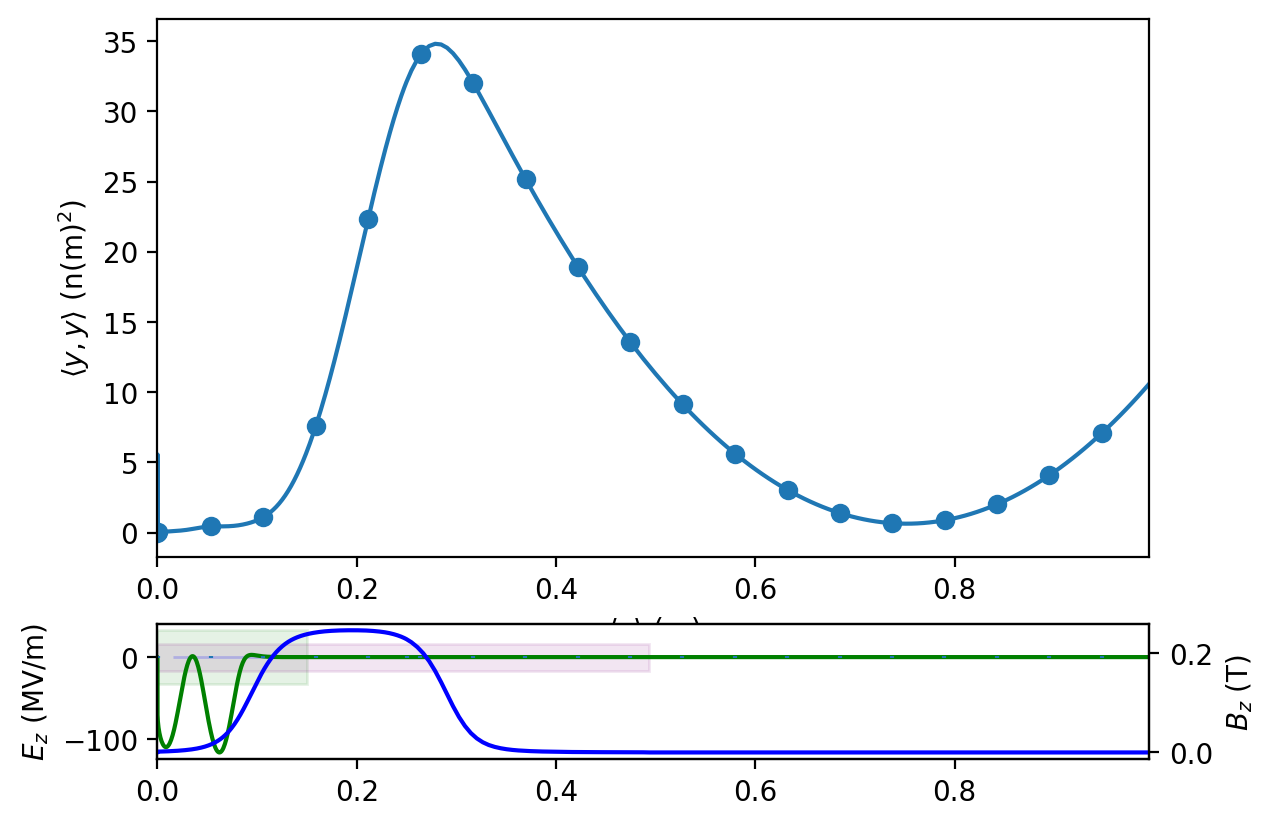

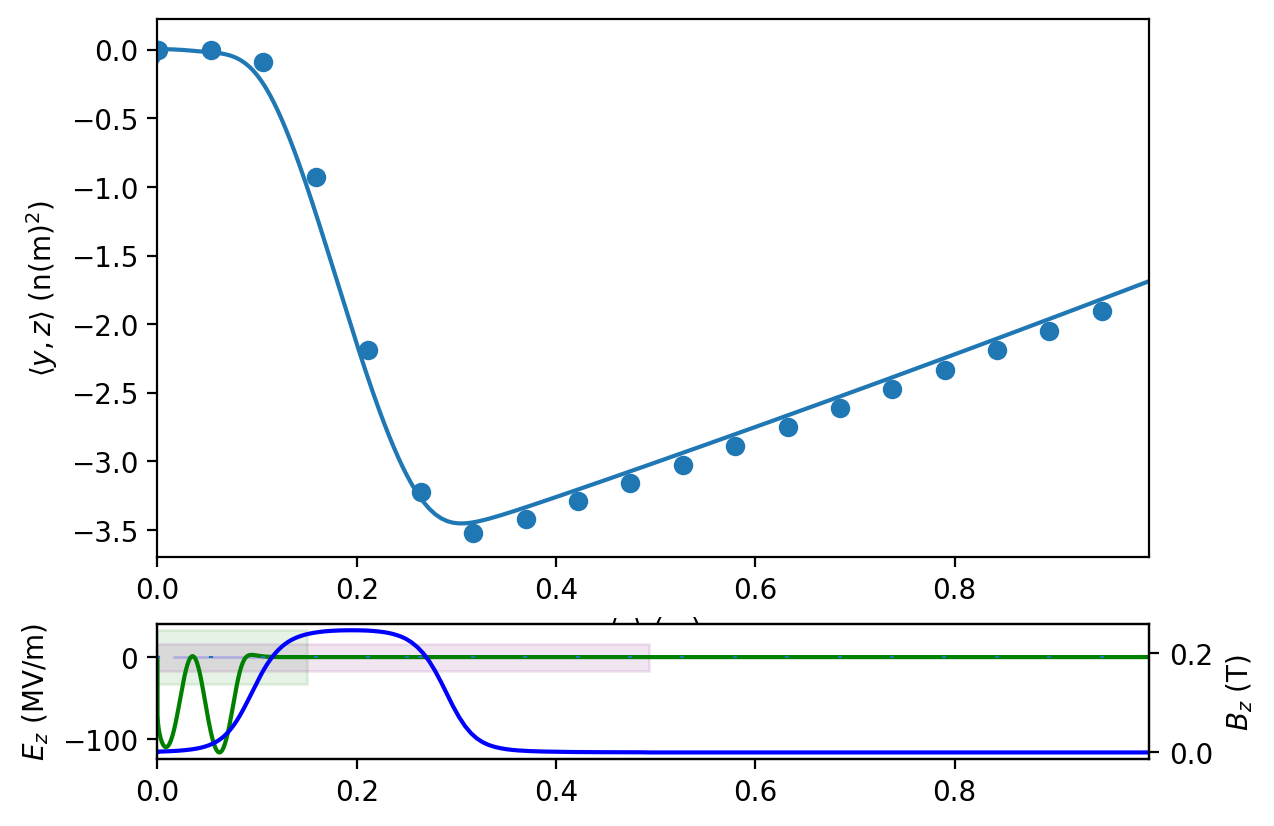

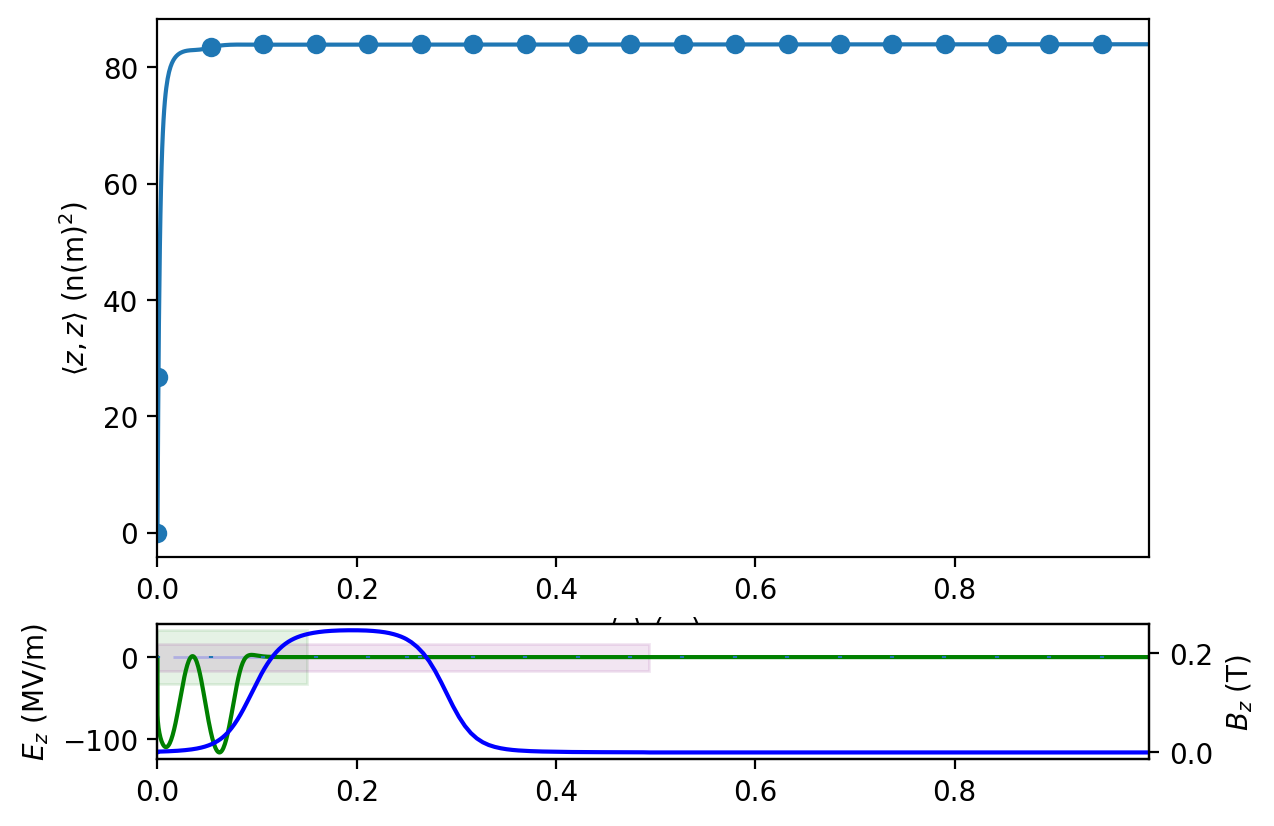

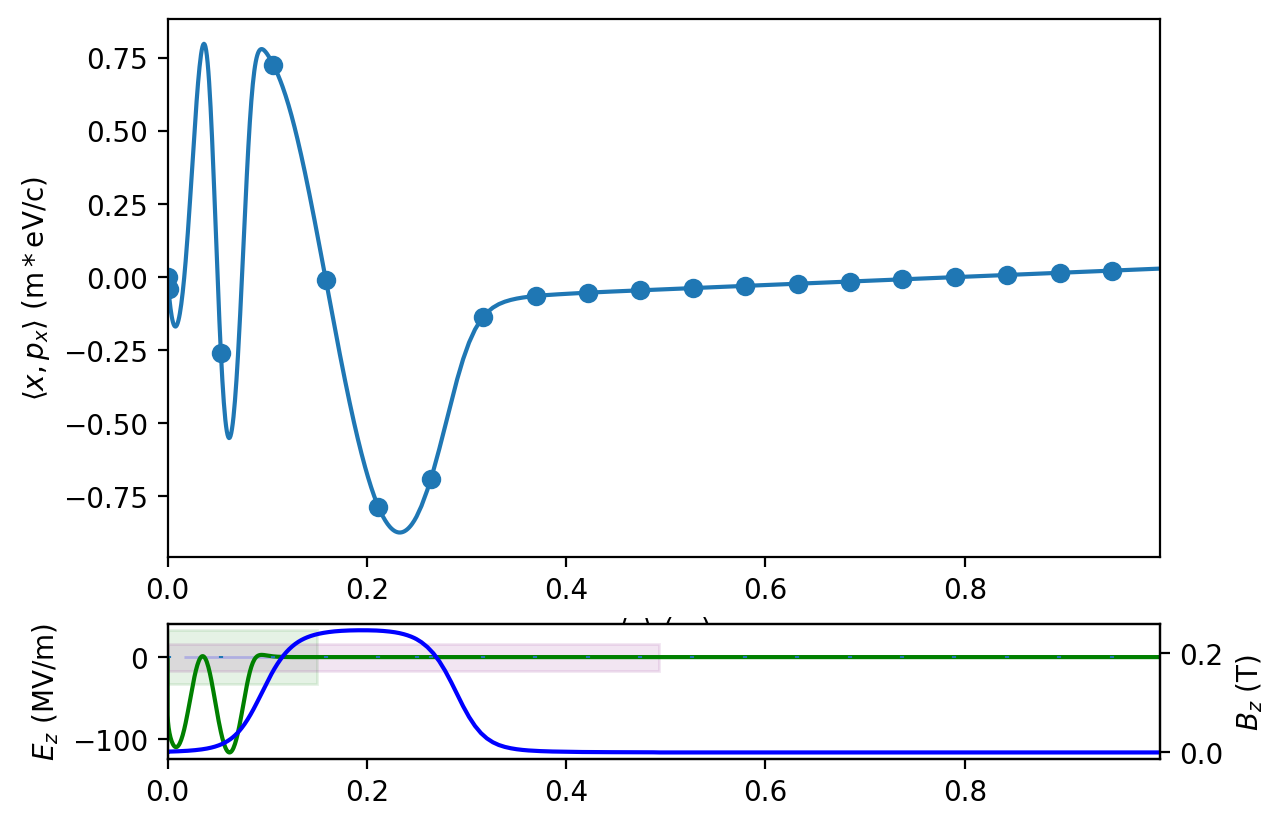

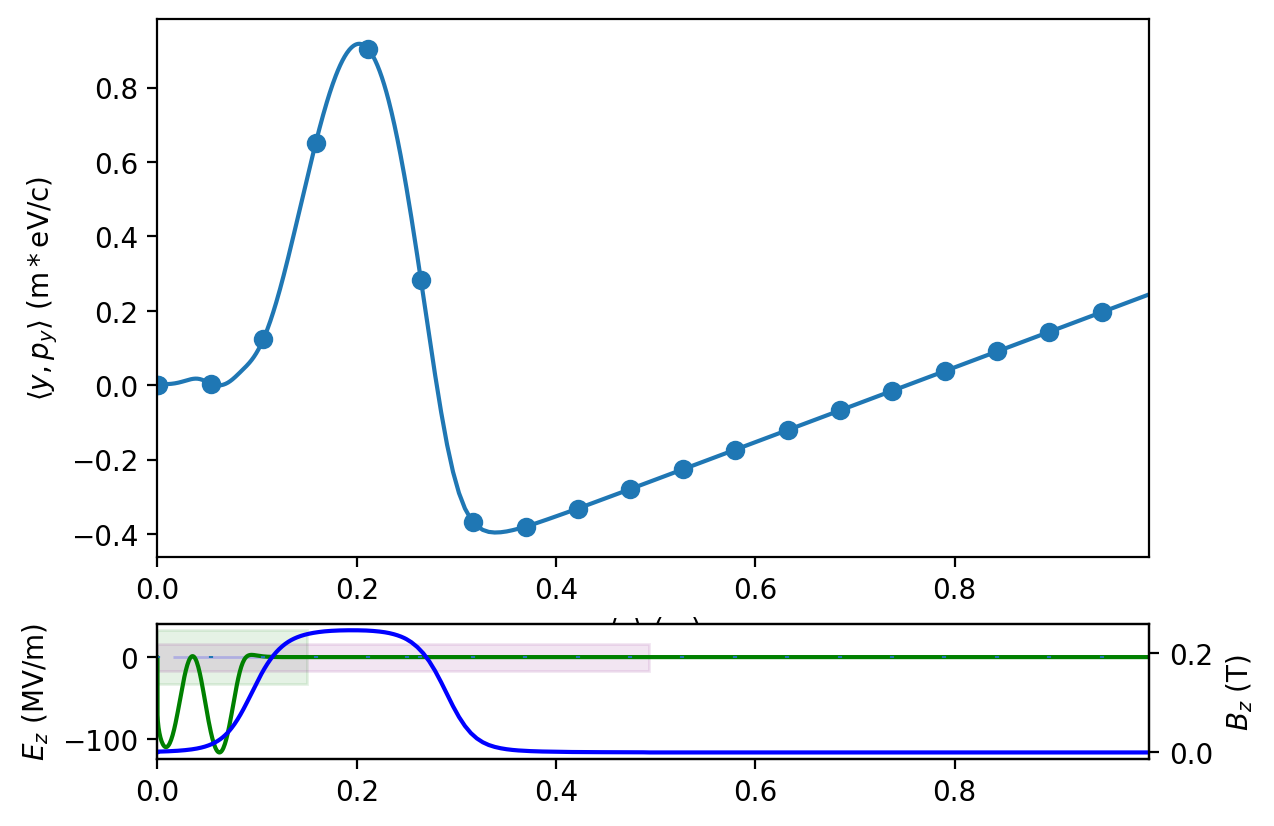

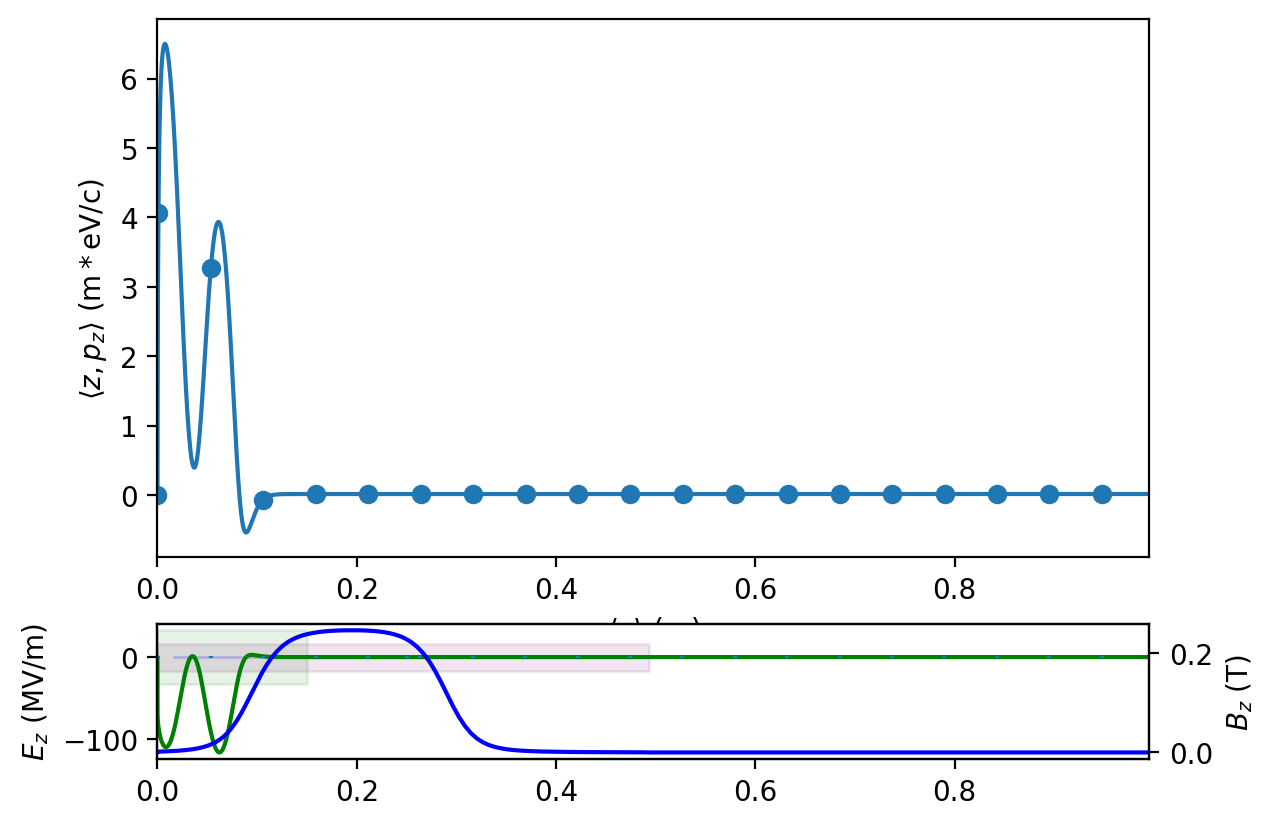

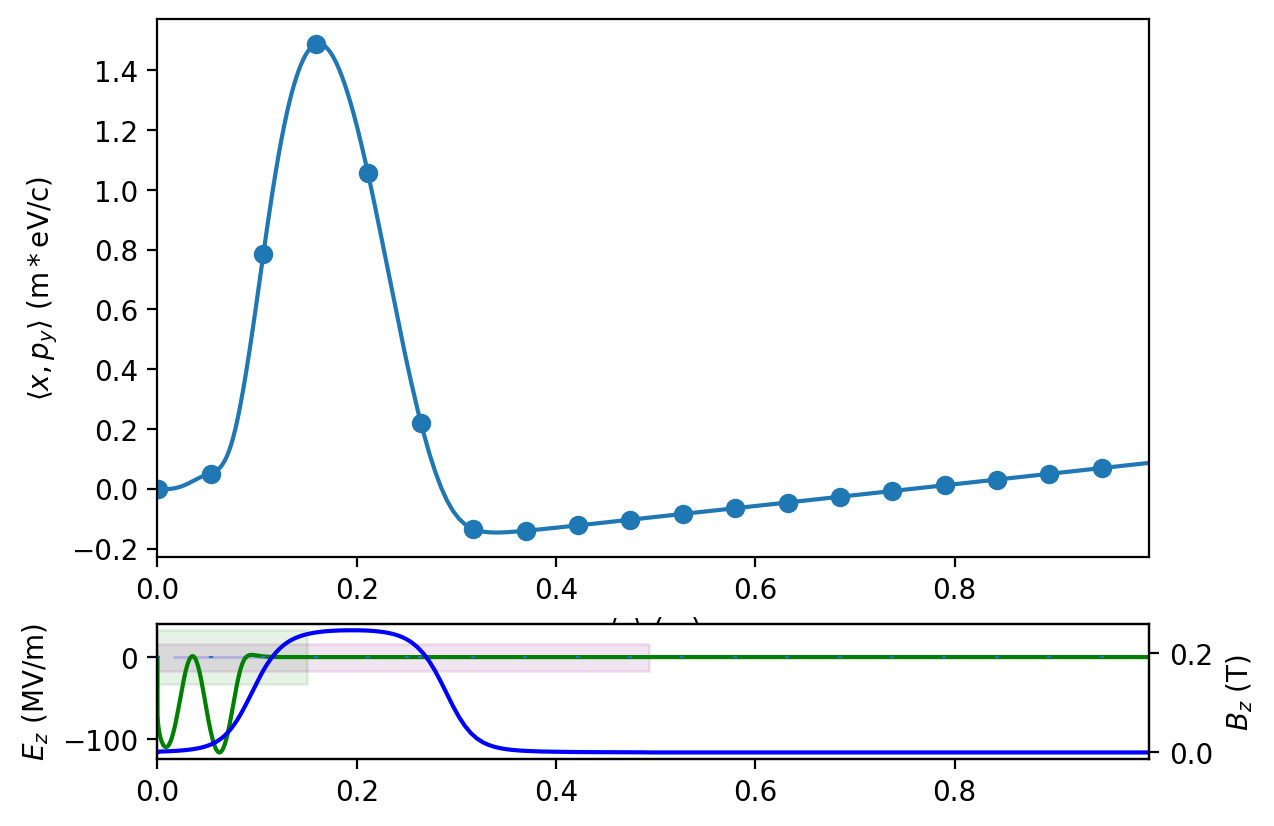

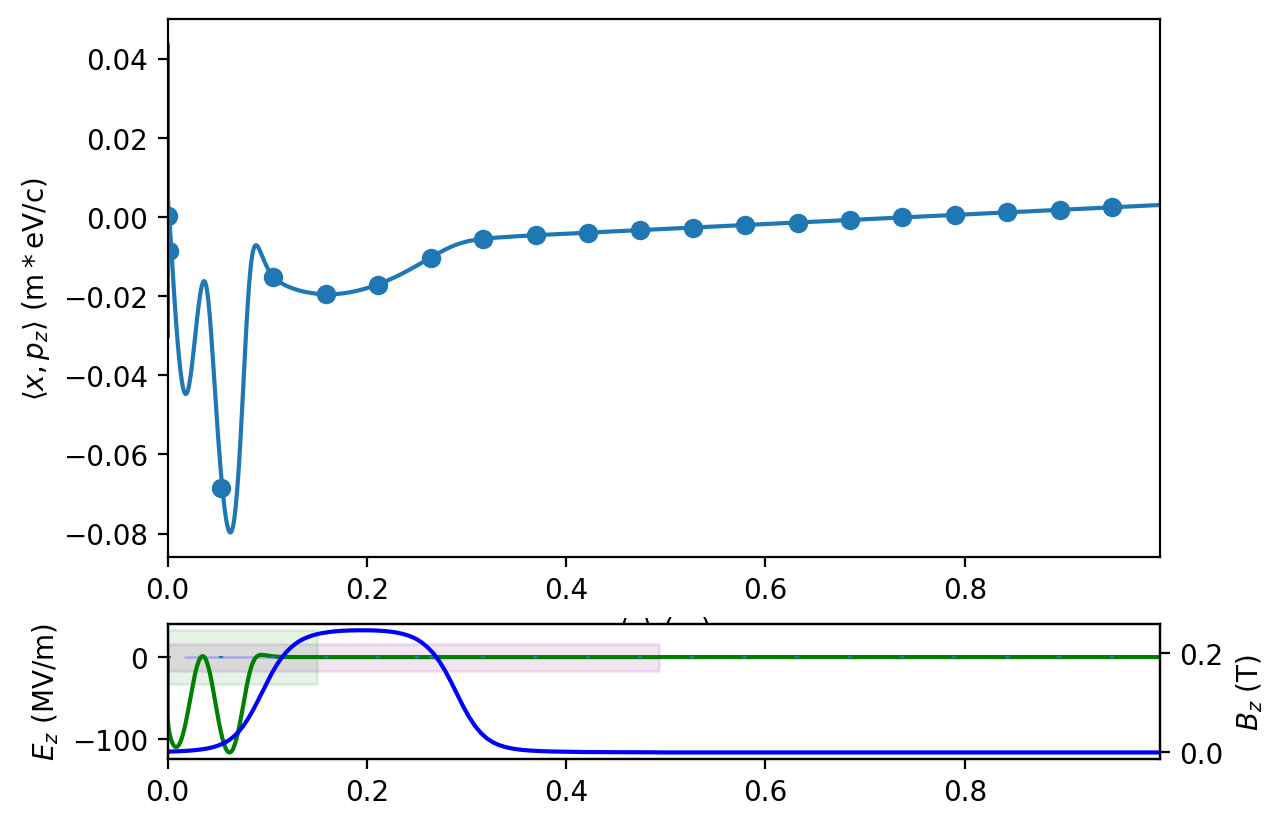

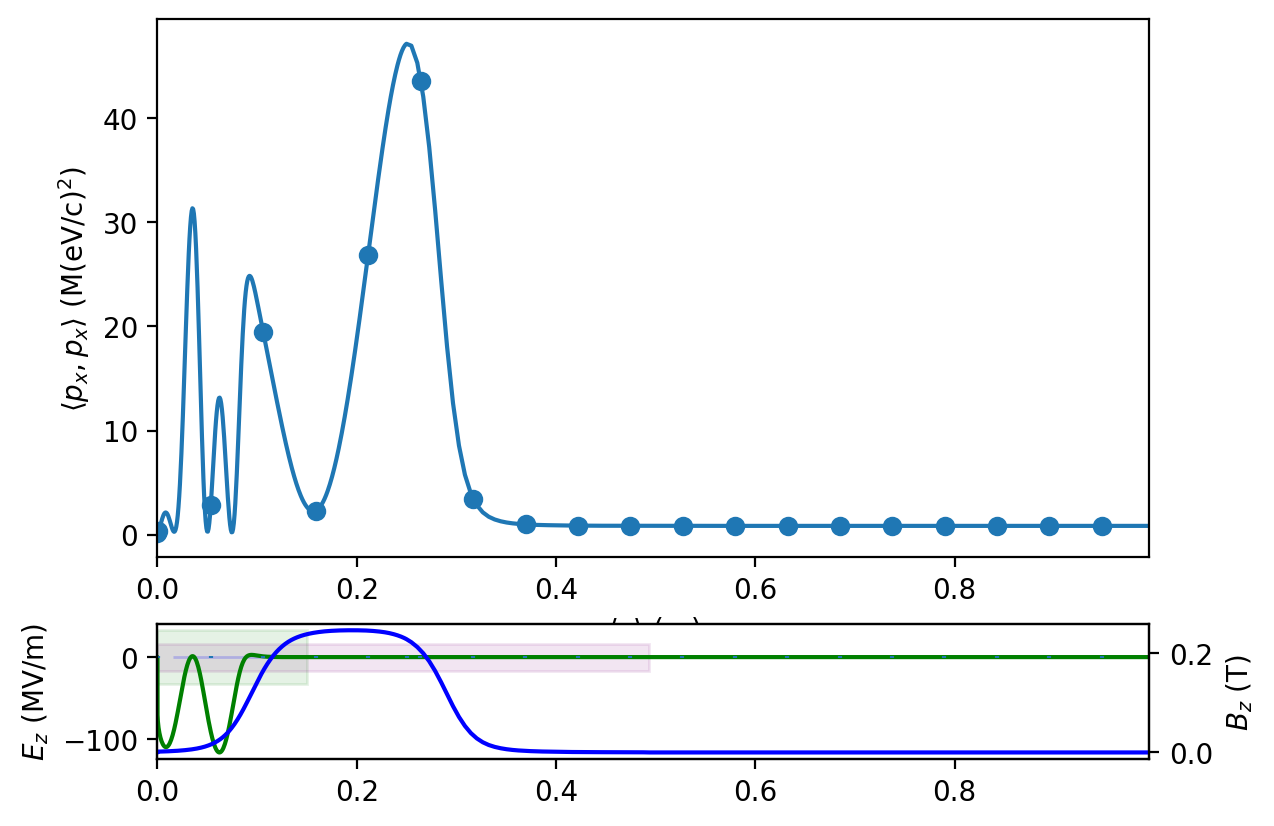

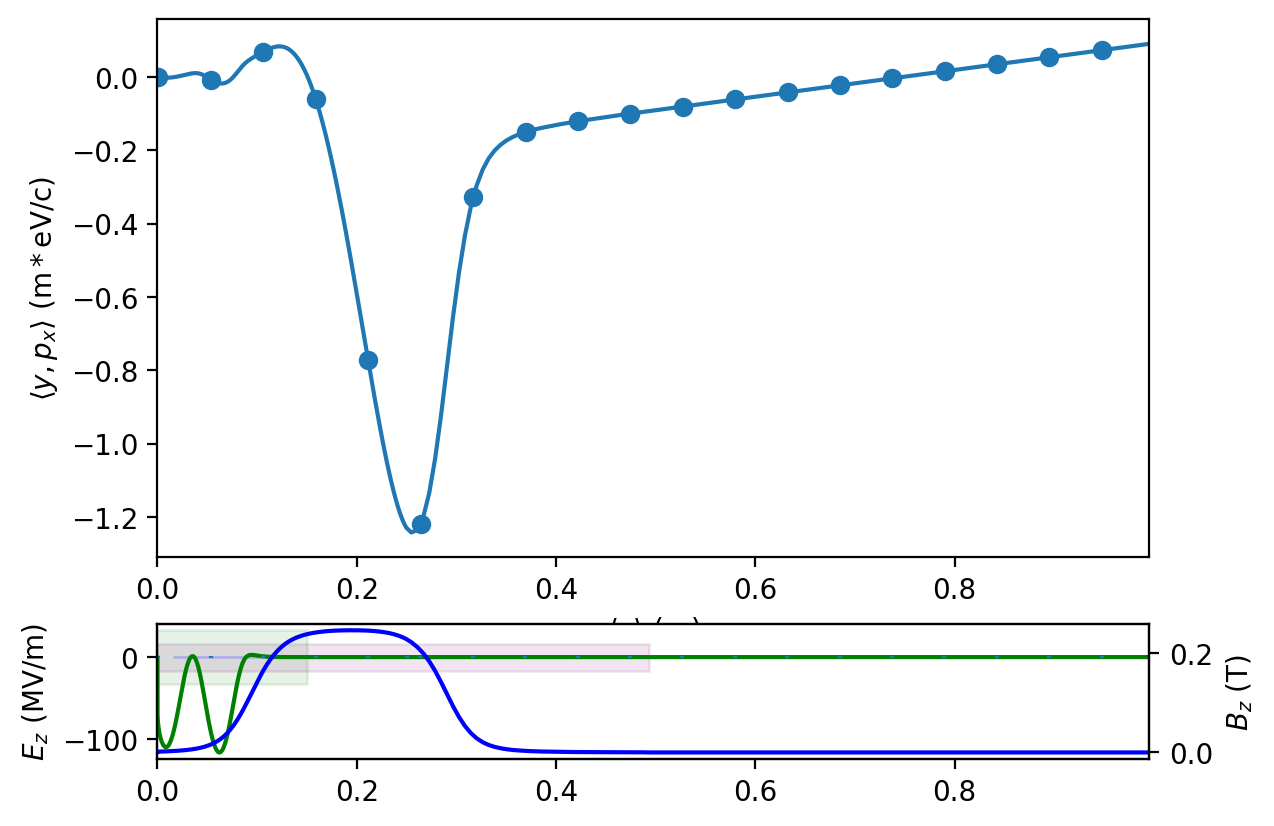

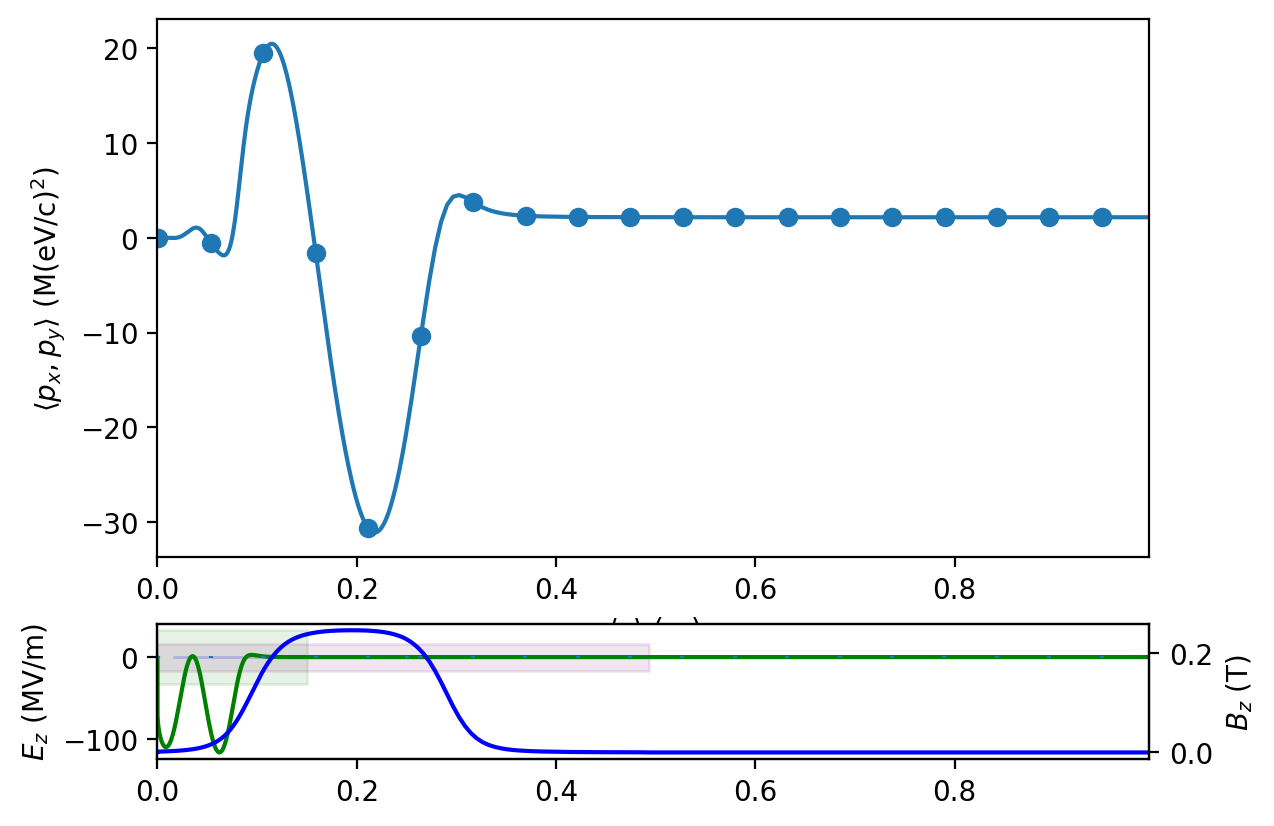

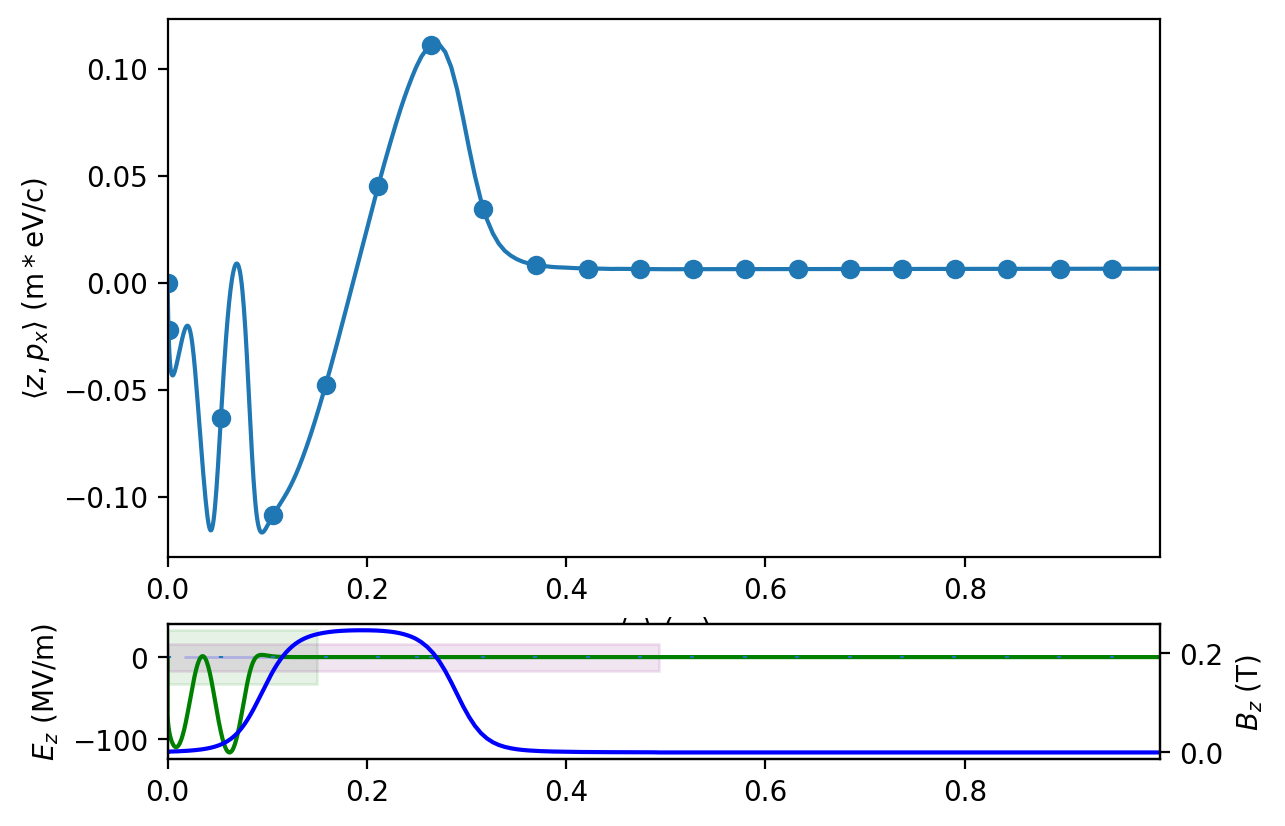

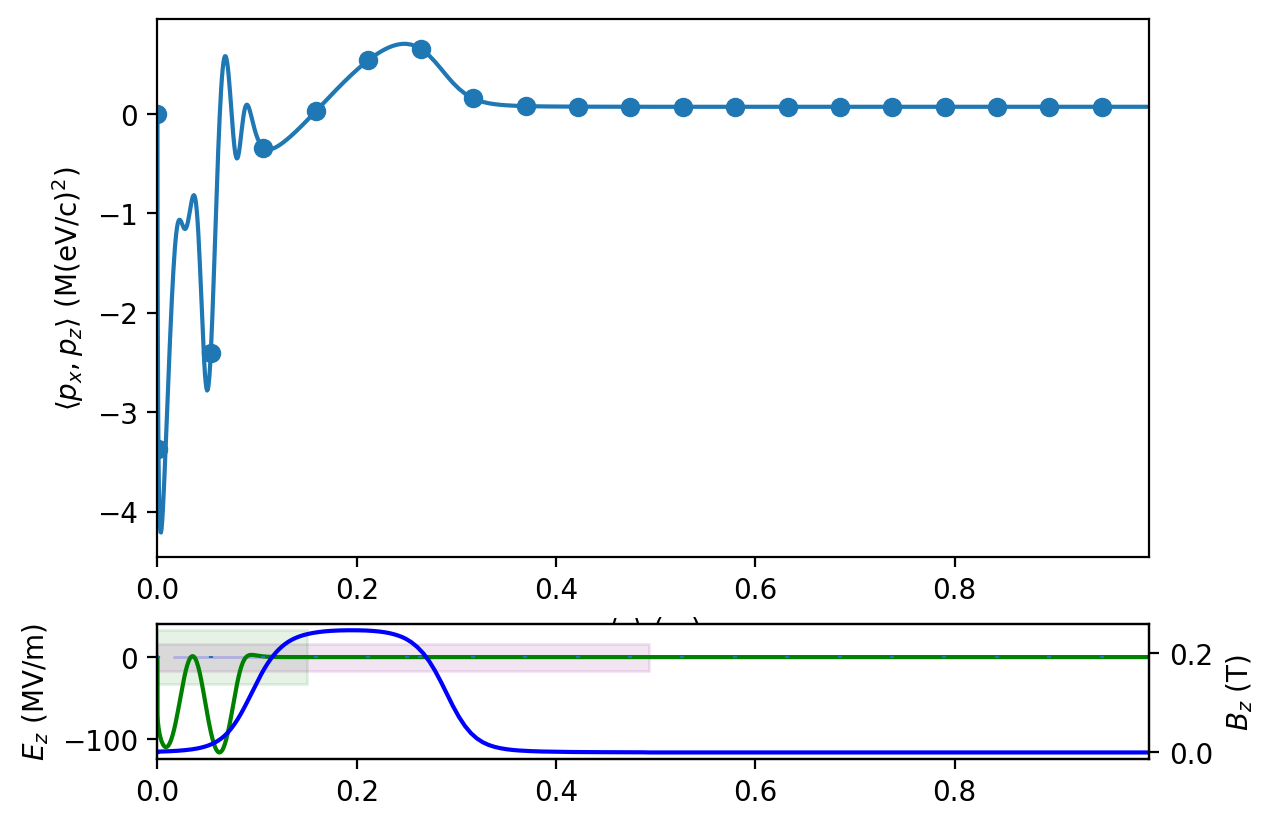

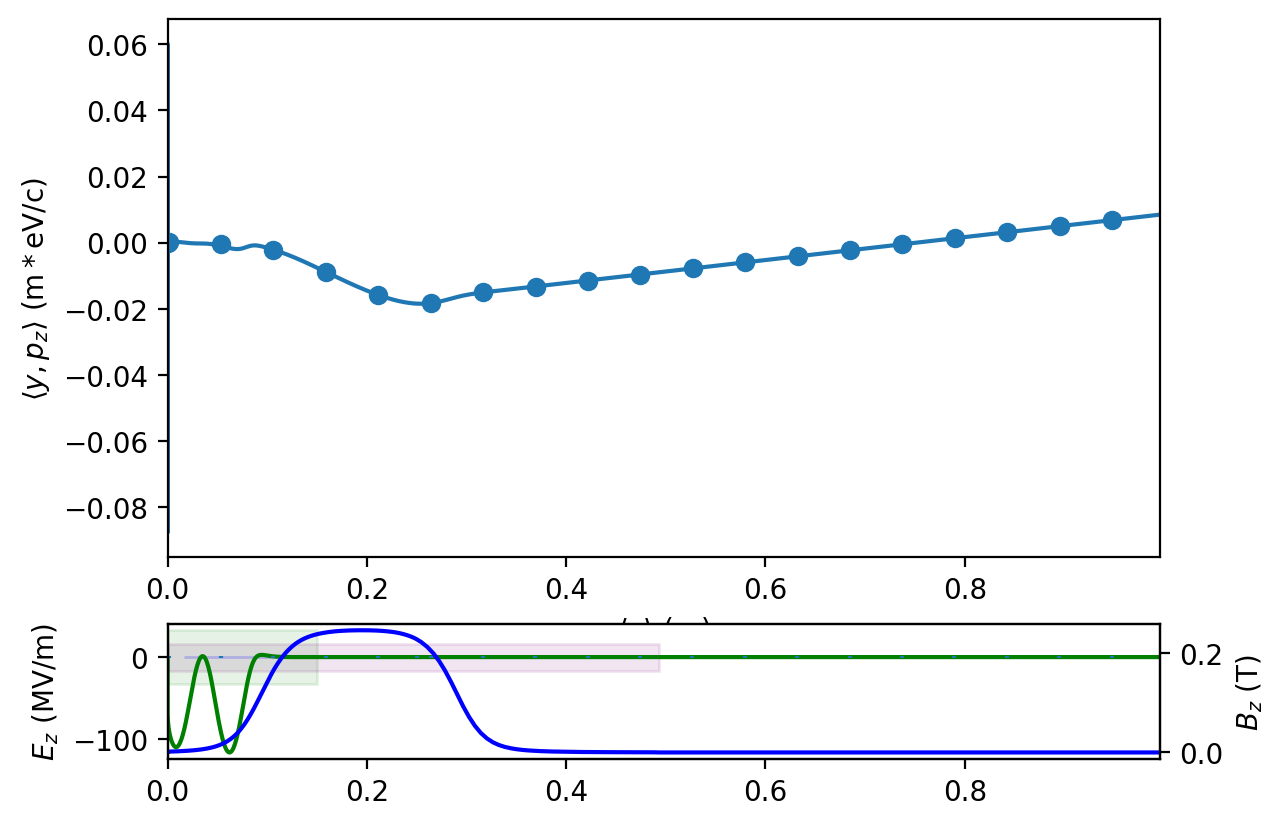

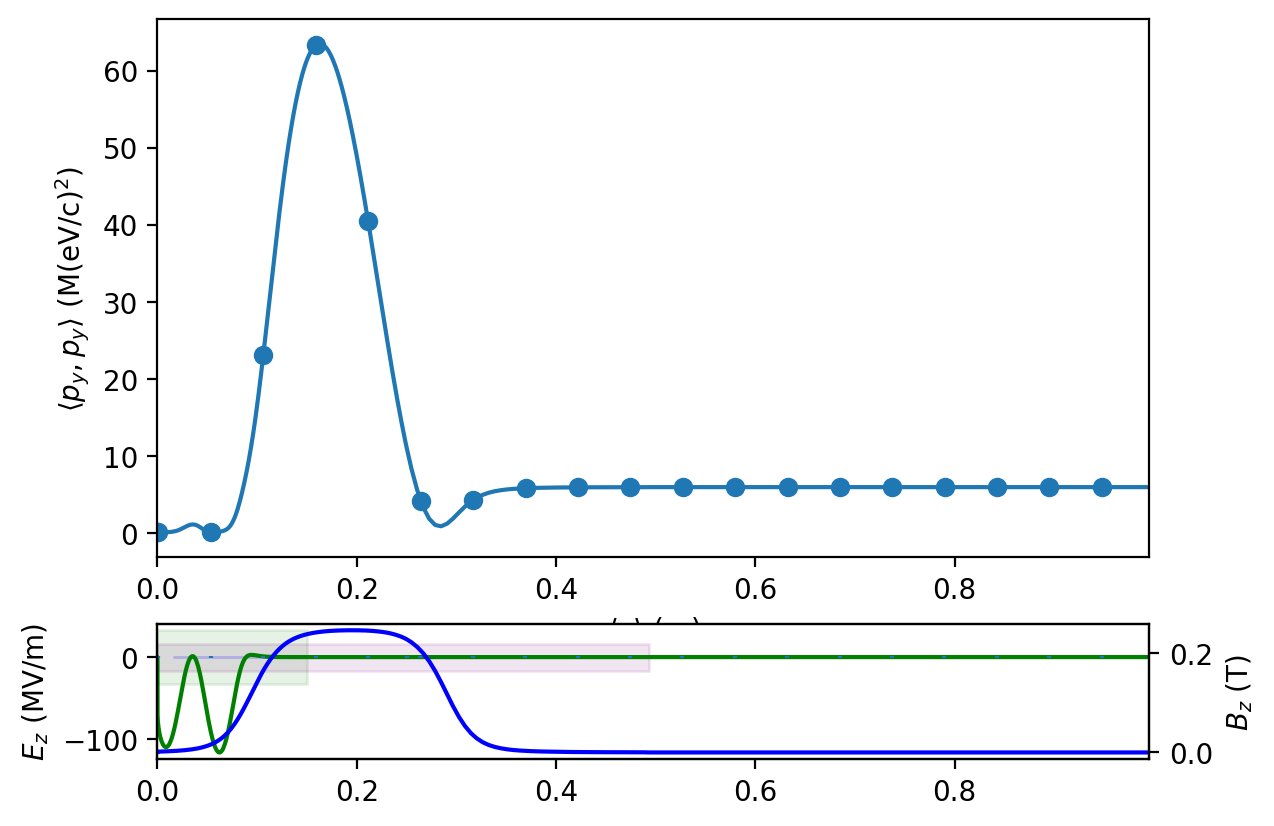

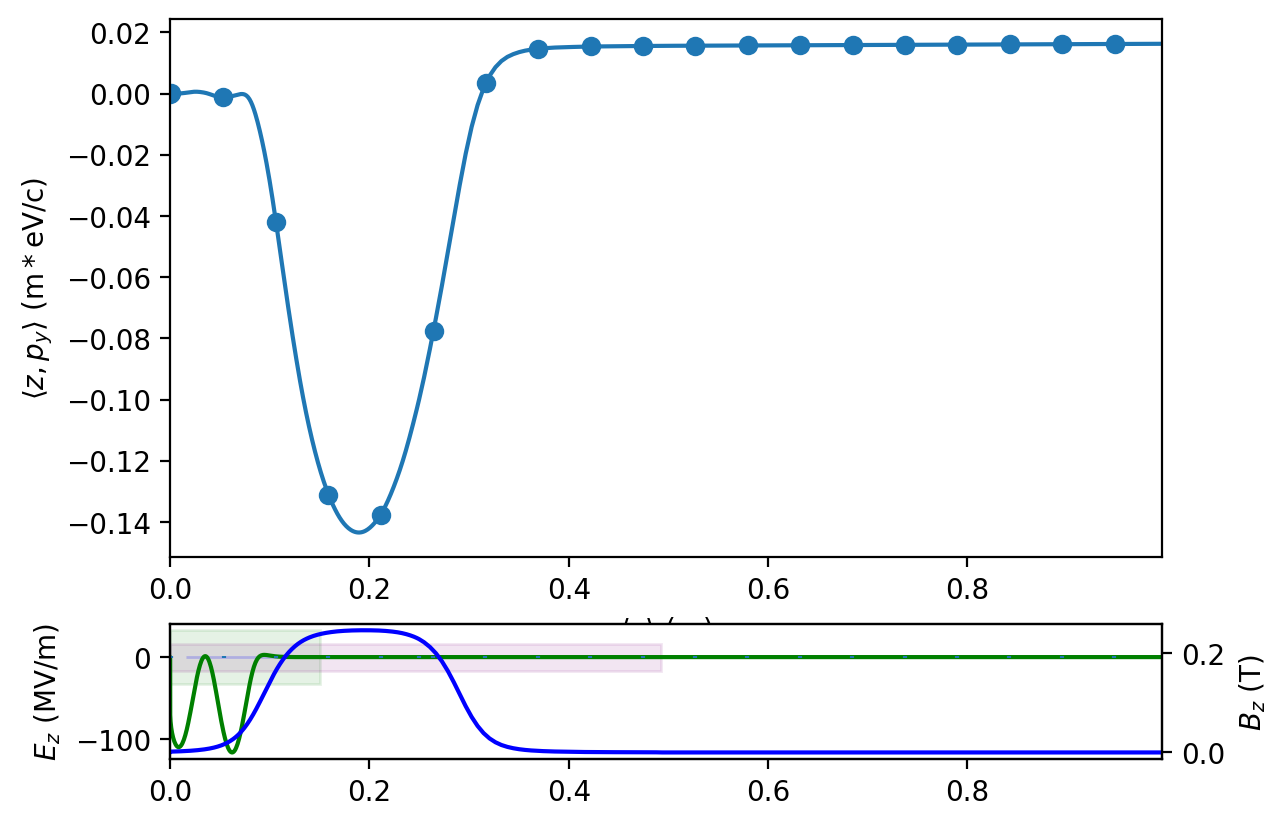

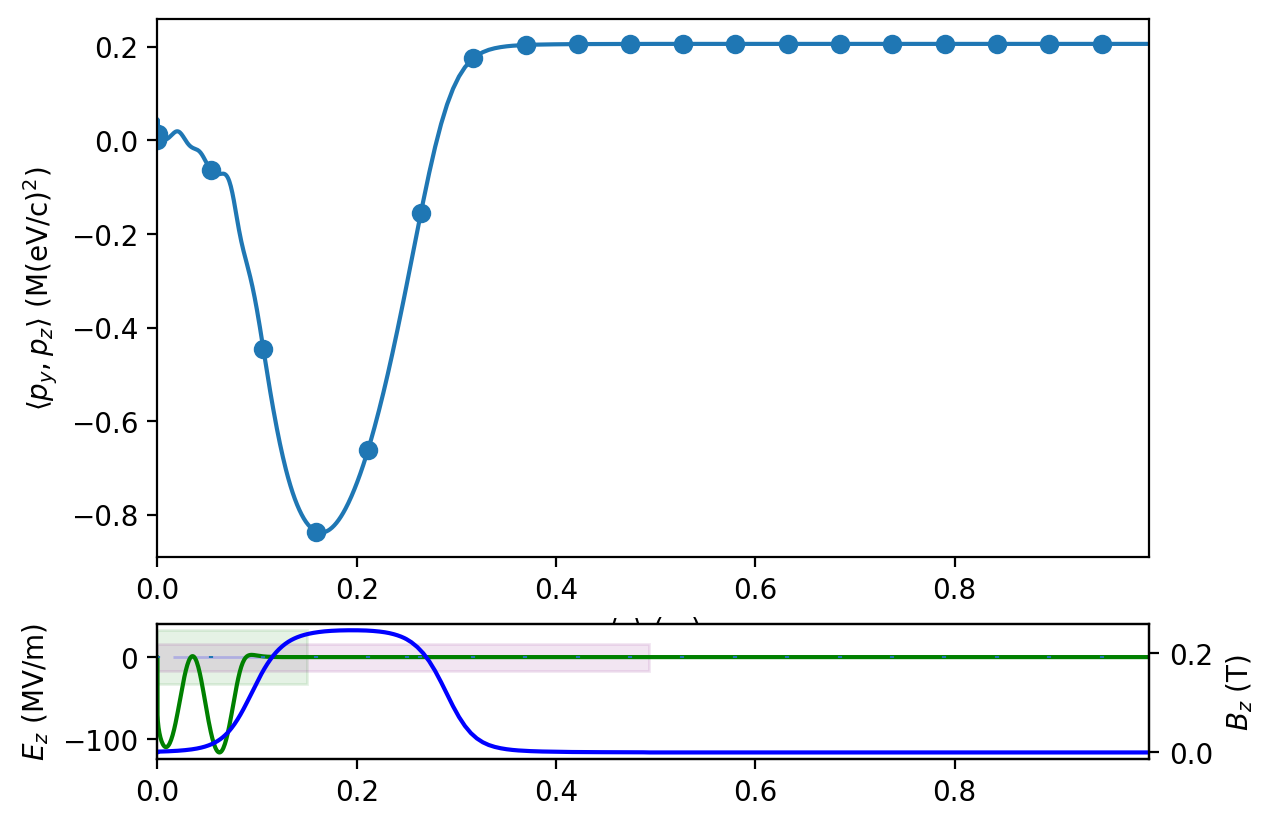

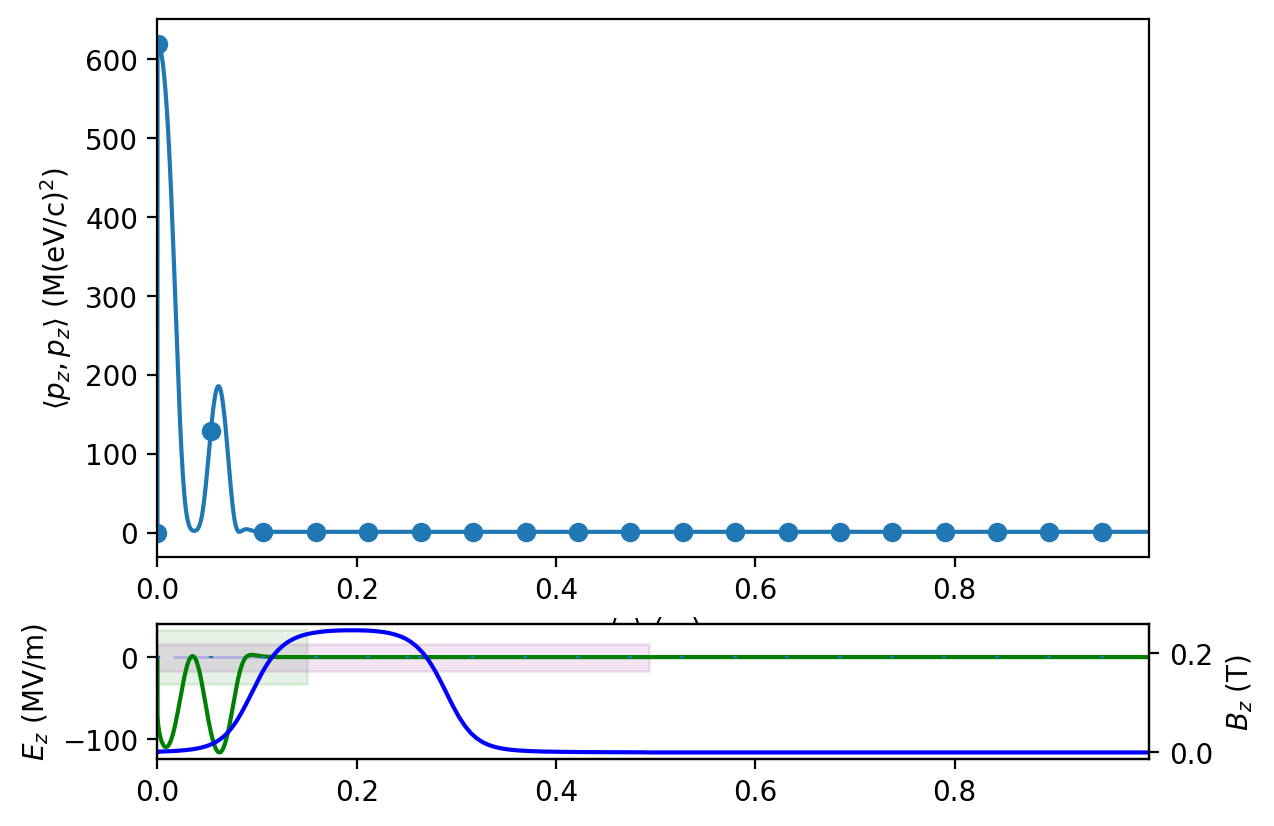

In [20]:
plot_all_cov(Iz)  